## RMIT, MATH2350, Introduction to Analytics
## Group Assignment, Semester 2, 2019

### Group 37

Group Members
* Bernard O'Meara: s8358478
* Inci Keleher: s3646416
* Blaise Saunders: s3561722
* Hunter Varghese: s3603696

# Predicting Melbourne House Prices using Linear Regression

## Contents:

* [Overview](#overview)
  * [Introduction](#introduction)
  * [Data Source](#data_source)
  * [Project Objective](#project_objective)
  * [Target Feature](#target_feature)
  * [Descriptive Features](#descriptive_features)
* [Data preparation](#data_prep)
  * [Preliminaries](#prelim)
  * [Read in the dataset](#read_in_the_dataset)
  * [Inspect Raw Data](#inspect_raw_data)
* [Data Cleaning](#data_cleaning)
  * [Remove redundant features](#remove_features)
  * [Prepare numeric variables](#prepare_numeric)
  * [Removing null values](#remove_null_values)
  * [Prepare categorical data](#prepare_categorical)
  * [Price normalisation](#normalise_price)
  * [Convert price to log](#price_to_log)
* [Exploring the Data](#explore_data)
  * [Numeric variables](#explore_numeric)
  * [Target variable](#explore_target)
  * [BuildingArea](#explore_building)
  * [Housing Type](#explore_type)
  * [Rooms](#explore_rooms)
* [Building the model](#building_model)
  * [Model 1](#model_one)
  * [Model 2](#model_two)
  * [Model 3](#model_three)
  * [Comparison](#compare)
* [Summary and conclusion](#summary)
* [References](#references)

# Overview <a name="overview"></a>



## Introduction <a name="introduction"></a>

The objective of this project is to predict Melbourne Property Prices using the Kaggle Melbourne housing full data set. The data set was sourced from https://www.kaggle.com/anthonypino/melbourne-housing-market (Kaggle, 2019) and is hosted on https://raw.githubusercontent.com/Bernie059/datasets/master (O'Meara, 2019).

## Data Source <a name="data_source"></a>

The Kaggle Melbourne Housing full dataset contains 21 variables: 12 numerical and 9 categorical. The target variable is a new continuous variable, derived by finding the logarithm of Price. An additional numerical variable, Age, was generated by subtracting the YearBuilt from 2019 and used in place of YearBuilt.

The dataset originaly contaied 34,857 rows of data. However, many rows had missing data and so where discarded. Furthermore, columns of an ID like nature and redundant data columns were discarded.

The resulting dataset for regression contains 7 numerical predictor variables, 3 categorical variables, 1 numerical target variable, and a total of 8,808 rows of data.

## Project Objective <a name="project_objective"></a>

The primary objective of this project is to construct and evaluate a linear regression model that predicts Melbourne house prices. The dataset contains numerous objective metrics. However, it does not capture subjective features which can have a substantial effect on housing prices (e.g., view, luxuary appointment, condition, quality of local schools etc). Therefore, this project aims to counter the missing subjective data by by using the log of housing prices.

A secondary pedagogical objective, is to compare differing regression models ranging from naive implementations containing all of the reduced set of predictors through to a technically correct model which sequentially removes  predictors with a p-value greater than 5%.


## Target Feature <a name="target_feature"></a>

The target feature is the logarithm (base 10) of housing prices, which is a continuous numerical feature. Hence, this project is a regression problem.

## Descriptive Features <a name="descriptive_features"></a>

The varables below are from the Melbourne_housing_FULL.csv file:
* Suburb : The suburb the property is located in.
* Address : The street address of the property.
* Rooms : The number of rooms in the property.
* Type : The type of property, House, Unit or Terrace.
* Price : The recorded sale price of the property.
* Method : Sold, Sold Privately, Vendor Bid, Passed In, Sold After auction.
* SellerG : Agents name.
* Date : Date of the sale.
* Distance : Distance from the Melbourne GPO.
* Postcode : Postcode of the property.
* Bedroom2 : number of bedrooms.
* Bathroom Number of bathrooms.
* Car : Number of car parking spots.
* Landsize : Size of the land.
* BuildingArea : Size of the building.
* YearBuilt : Year the property was built.
* CouncilArea : The council area the property is in.
* Lattitude : The lattitude of the property.
* Longtitude : The longtitude of the property.
* Regionname : The region name the property is in.
* Propertycount : The number of unique properties in the same area, (Suburb and postcode)

Additional feature added. 
* Age : The number or years since the house was built prior to 2019. 
* logPrice : The log base10 of Price (target variable).

# Data Preparation <a name="data_prep"></a>

## Preliminaries <a name="prelim"></a>

In [312]:
# core python imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math
from time import time
warnings.filterwarnings('ignore')

# statistical imports
from scipy import stats
#from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols
import patsy

# Styling
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use("ggplot")
from IPython.display import display, HTML

## Read in the dataset <a name="read_in_the_dataset"></a>

In [313]:
# import the melbourne property prices full dataset
raw = pd.read_csv('https://raw.githubusercontent.com/Bernie059/datasets/master/Melbourne_housing_FULL.csv')

In [314]:
raw.shape

(34857, 21)

In [315]:
df = raw.copy()

## Inspect raw data <a name="inspect_raw_data"></a>

In [316]:
df.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,3/09/2016,2.5,3067.0,...,1.0,1.0,126.0,NaN,NaN,Yarra City Council,-37.8014,144.9958,Northern Metropolitan,4019.0
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0
3,Abbotsford,18/659 Victoria St,3,u,NaN,VB,Rounds,4/02/2016,2.5,3067.0,...,2.0,1.0,0.0,NaN,NaN,Yarra City Council,-37.8114,145.0116,Northern Metropolitan,4019.0
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0


In [317]:
df.dtypes

Suburb            object
Address           object
Rooms              int64
Type              object
Price            float64
Method            object
SellerG           object
Date              object
Distance         float64
Postcode         float64
Bedroom2         float64
Bathroom         float64
Car              float64
Landsize         float64
BuildingArea     float64
YearBuilt        float64
CouncilArea       object
Lattitude        float64
Longtitude       float64
Regionname        object
Propertycount    float64
dtype: object

# Data cleaning <a name="data_cleaning"></a>

## Remove ID like and redundant features <a name="remove_features"></a>
* Address is ID like in that it describes a unique property. It can be argued that individual streets can contribute to the value of a property. However, fine grained analysis down to the street level is beyond the scope of this report. Therefore, Address will be dropped.<br>


* Longtitude and Lattitude individually are a line on a map. Combined they pinpoint a unique property which is an ID like attribute. The geographic qualities of Longnitude and Lattitude are redundant as they overlap the information from Postcode, Suburb, Distance CouncilArea and Regionname. Therefore, Longtitude and Lattitude will be dropped.


* The data was collected over a period of a few years. However, this report is treating the time as stationary and ignoring inflation over the period. Therefore, Date will be dropped. Before it is dropped we will use to to normalise the price data to compensate for inflation since 2016 and present prices in 2019 dollars as well as market movement in the housing market over the 2016-2018 time period. Inflation and housing market data was sourced from https://tradingeconomics.com<br>


* Regionname, Suburb, CouncilArea and Postcode all refer to the geographic location of the property. Regionname is less precise than Suburb and Postcode. Therefore Regionname will be dropped.<br> 


* Suburb and Postcode are almost identical. Because humans are subjective in their valuations and most commonly refer to Suburb over Postcode when forming an opinion of property value. Suburb will be retained and Postcode will be dropped.<br>


* The information contained in CouncilArea is covered by Suburb and is therfore redundant. CouncilArea will be dropped.<br>


* The information contained in Distance is duplicated in the Suburb variable. Therefore, Distance will be dropped.<br>


* Propertycount adds no usefull information for analysis. Therefore, propertyCount will be dropped.<br>


* SellerG adds no usefull information for analysis. Therefore, SellerG will be dropped.



In [318]:
df = df.drop(columns=['Address', 'Longtitude', 'Lattitude', 'Regionname', 'Postcode', 'CouncilArea', 'Distance', 'Propertycount', 'SellerG'])

In [319]:
df.columns

Index(['Suburb', 'Rooms', 'Type', 'Price', 'Method', 'Date', 'Bedroom2',
       'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt'],
      dtype='object')

## Prepare numeric variables <a name="prepare_numeric"></a>

In [320]:
df.sample(5)

,Suburb,Rooms,Type,Price,Method,Date,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt
24161,Ardeer,4,h,NaN,PI,14/10/2017,4.0,1.0,3.0,604.0,NaN,NaN
16007,Toorak,2,u,NaN,S,17/06/2017,2.0,2.0,2.0,1488.0,NaN,NaN
11926,Oakleigh,3,h,1050000.0,SP,15/10/2016,3.0,2.0,2.0,544.0,146.0,1970.0
1724,Braybrook,3,h,765000.0,S,25/02/2017,3.0,1.0,1.0,658.0,105.0,1960.0
32178,Taylors Lakes,4,h,1136000.0,SP,3/03/2018,4.0,3.0,2.0,700.0,291.0,2007.0


In [321]:
# describe the continuous variables
df.describe()

,Rooms,Price,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt
count,34857.000000,2.724700e+04,26640.000000,26631.000000,26129.000000,23047.000000,13742.00000,15551.000000
mean,3.031012,1.050173e+06,3.084647,1.624798,1.728845,593.598993,160.25640,1965.289885
std,0.969933,6.414671e+05,0.980690,0.724212,1.010771,3398.841946,401.26706,37.328178
min,1.000000,8.500000e+04,0.000000,0.000000,0.000000,0.000000,0.00000,1196.000000
25%,2.000000,6.350000e+05,2.000000,1.000000,1.000000,224.000000,102.00000,1940.000000
50%,3.000000,8.700000e+05,3.000000,2.000000,2.000000,521.000000,136.00000,1970.000000
75%,4.000000,1.295000e+06,4.000000,2.000000,2.000000,670.000000,188.00000,2000.000000
max,16.000000,1.120000e+07,30.000000,12.000000,26.000000,433014.000000,44515.00000,2106.000000


Exploring the describe table above. It can be seen that there are properties with.
* No price entered in the Price field.
* Zero values in the Distance, Bedroom2, Bathroom and BuildingArea columns.
These data rows will be removed.<br>
NB: Zero in Car or Landsize is acceptable as many properties do not have a car parking space and units may not have a landsize quoted..<br> 

## Remove rows with na or zero values that should not be zero <a name="remove_null_values"></a>

In [322]:
# remove all rows with nan values
df.dropna(inplace=True)
# remove rows that have zero for Bedroom2 or less than 10 m^2 BuildingArea
df = df[(df.Bedroom2 > 0.0) & (df.BuildingArea > 10.0)]

## Remove incorect formatting for YearBuilt
There is one property with the date as mmyy rather than yyyy, it will be removed.

In [323]:
print(df[df.YearBuilt < 1600].shape)
df = df[(df.YearBuilt > 1600)]

(1, 12)


## Add a new column 'Age' being (2019 - YearBuilt)

In [324]:
df['Age'] = 2019 - df.YearBuilt

Age replaces YearBuilt. Therefore, YearBuilt will be dropped.

In [325]:
df = df.drop(columns=['YearBuilt'])

In [326]:
# describe the continuous variables
df.describe()

,Rooms,Price,Bedroom2,Bathroom,Car,Landsize,BuildingArea,Age
count,8808.000000,8.808000e+03,8808.000000,8808.000000,8808.000000,8808.000000,8808.000000,8808.000000
mean,3.098320,1.092925e+06,3.078906,1.646571,1.692893,523.773728,150.665454,53.248524
std,0.964385,6.792276e+05,0.964227,0.722458,0.977566,1064.124110,87.159034,36.131217
min,1.000000,1.310000e+05,1.000000,1.000000,0.000000,0.000000,11.000000,0.000000
25%,2.000000,6.410000e+05,2.000000,1.000000,1.000000,212.750000,100.000000,19.000000
50%,3.000000,9.000000e+05,3.000000,2.000000,2.000000,479.000000,132.300000,49.000000
75%,4.000000,1.345250e+06,4.000000,2.000000,2.000000,652.000000,181.000000,74.000000
max,12.000000,9.000000e+06,12.000000,9.000000,10.000000,42800.000000,3112.000000,189.000000


All numerical columns now have the same number of rows and their statistical values look reasonable.

In [327]:
df.dtypes

Suburb           object
Rooms             int64
Type             object
Price           float64
Method           object
Date             object
Bedroom2        float64
Bathroom        float64
Car             float64
Landsize        float64
BuildingArea    float64
Age             float64
dtype: object

## Prepare categorical data <a name="prepare_categorical"></a>

In [328]:
print('Unique values for Type')
print(df.Type.unique())
print('\nUnique values for Method')
print(df.Method.unique())

Unique values for Type
['h' 'u' 't']

Unique values for Method
['S' 'SP' 'VB' 'PI' 'SA']


Categorical values Type and Method need no modification.

In [329]:
suburbs = ''
counter = 0
for sub in df.Suburb.unique():
  suburbs = '%s %-20s' % (suburbs, sub)
  counter += 1
  if counter % 5 == 0:
    suburbs += '\n'
      
print(suburbs)  

 Abbotsford           Airport West         Albert Park          Alphington           Altona              
 Altona North         Armadale             Ascot Vale           Ashburton            Ashwood             
 Avondale Heights     Balaclava            Balwyn               Balwyn North         Bentleigh           
 Bentleigh East       Box Hill             Braybrook            Brighton             Brighton East       
 Brunswick            Brunswick West       Bulleen              Burwood              Camberwell          
 Canterbury           Carlton North        Carnegie             Caulfield            Caulfield North     
 Caulfield South      Chadstone            Clifton Hill         Coburg               Coburg North        
 Collingwood          Doncaster            Eaglemont            Elsternwick          Elwood              
 Essendon             Essendon North       Fairfield            Fitzroy              Fitzroy North       
 Flemington           Footscray            Gle

In [330]:
# describe the categorical variables
df.describe(include='object')

,Suburb,Type,Method,Date
count,8808,8808,8808,8808
unique,315,3,5,77
top,Reservoir,h,S,24/02/2018
freq,191,6576,5553,227


## Replace whitespace in Suburb names with underscores
The list of suburbs shows whitespace within the names. These will be replaced with underscores.

In [331]:
df.Suburb = df.Suburb.str.replace(' ', '_')

Categorical data now looks reasonable and is ready for the regression model.

## Normalise price data to compensate for inflation and house price increases <a name="normalise_price"></a>

Before we normalise the house prices we will convert all dollar amounts to 2019 dollars

In [332]:
df.columns
df.head(5)

,Suburb,Rooms,Type,Price,Method,Date,Bedroom2,Bathroom,Car,Landsize,BuildingArea,Age
2,Abbotsford,2,h,1035000.0,S,4/02/2016,2.0,1.0,0.0,156.0,79.0,119.0
4,Abbotsford,3,h,1465000.0,SP,4/03/2017,3.0,2.0,0.0,134.0,150.0,119.0
6,Abbotsford,4,h,1600000.0,VB,4/06/2016,3.0,1.0,2.0,120.0,142.0,5.0
11,Abbotsford,3,h,1876000.0,S,7/05/2016,4.0,2.0,0.0,245.0,210.0,109.0
14,Abbotsford,2,h,1636000.0,S,8/10/2016,2.0,1.0,2.0,256.0,107.0,129.0


In [333]:
#we want to normalise price using date, and then drop date later
import time

#split the date object string to get the year
df['Date'] = pd.to_datetime(df['Date'])
df['year'], df['month'] = df['Date'].dt.year, df['Date'].dt.month
print("sample of years covered:")
print(df['year'].sample(20))


#range of dates
print("range")
date_min = min(df['Date'])
date_max = max(df['Date'])
print(date_min)
print(date_max)

smallest_timestamp = time.mktime(date_min.timetuple())
largest_timestamp = time.mktime(date_max.timetuple())

dates = df['Date'].tolist()
prices = df['Price'].tolist()

# we use the round function and times by 6 to split into 6 buckets for which we have price icnreases/decreases
# buckets correspond to financial quarters this will normalise prices for housing market fluctuations
# and inflation since 2019

buckets_market =    [-0.2, 2, 1.5, 4.1, 2.2, 1.9, -0.2, 1,  -0.7, -0.7, -1.5]
buckets_inflation = [1.3,  1, 1.3, 1.5, 2.1, 1.9,  1.8, 1.9, 1.9,  2.1,  1.9]

# we normalise the entire list of all prices e.g.
# 720000-(720000*0.015) = price-(price*pricechange)

i = 0
for date in dates:
    unixt = (time.mktime(date.timetuple()))
    normal = round((unixt - smallest_timestamp) / (largest_timestamp - smallest_timestamp)*len(buckets_market))

    if normal > len(buckets_market)-1:
      normal = len(buckets_market)-1
    
    #print("Price fell into bin: \t\t\t"+str(normal))
    #print("Price pre-normalization:\t\t"+str(prices[i]))
    # Lower by the inverse of price increase over time of house price for 5 month window
    # 30 month total
    prices[i] -= prices[i]*((buckets_market[normal])/100)
    #print("Price post-market-normalization:\t"+str(prices[i]))
    prices[i] += prices[i]*((buckets_inflation[normal])/100)
    #print("Price post-inflation-normalization:\t"+str(prices[i]))
    #print()
    #print()

    i += 1
    

#our date range is 979 days from first sale (day 0) to final sale recorded in our dataset
date_range = date_max - date_min

sample of years covered:
6912     2016
19223    2017
7675     2016
7801     2016
11150    2017
27112    2017
1020     2016
6740     2016
30037    2017
17646    2017
4556     2016
3944     2016
15016    2017
18466    2017
14480    2017
33096    2018
13646    2017
731      2017
73       2017
2404     2016
Name: year, dtype: int64
range
2016-03-09 00:00:00
2018-10-03 00:00:00


In [334]:
#insert normalised prices into model
df['Adj_Price'] = prices

df.head(5)

#we will now set Price to be our adjusted price and discard the unadjusted price, date, year and month
df['Price'] = df['Adj_Price']
df = df.drop(columns=['Date', 'year', 'month', 'Adj_Price'])

In [335]:
df.head(5)

,Suburb,Rooms,Type,Price,Method,Bedroom2,Bathroom,Car,Landsize,BuildingArea,Age
2,Abbotsford,2,h,1050551.910,S,2.0,1.0,0.0,156.0,79.0,119.0
4,Abbotsford,3,h,1464471.135,SP,3.0,2.0,0.0,134.0,150.0,119.0
6,Abbotsford,4,h,1624041.600,VB,3.0,1.0,2.0,120.0,142.0,5.0
11,Abbotsford,3,h,1856864.800,S,4.0,2.0,0.0,245.0,210.0,109.0
14,Abbotsford,2,h,1632408.980,S,2.0,1.0,2.0,256.0,107.0,129.0


## Convert Price to logPrice <a name="price_to_log"></a>

Price is many times larger than the predictors and heavily right skewed.
Therefore, we will generate a new column called logPrice and remove Price.

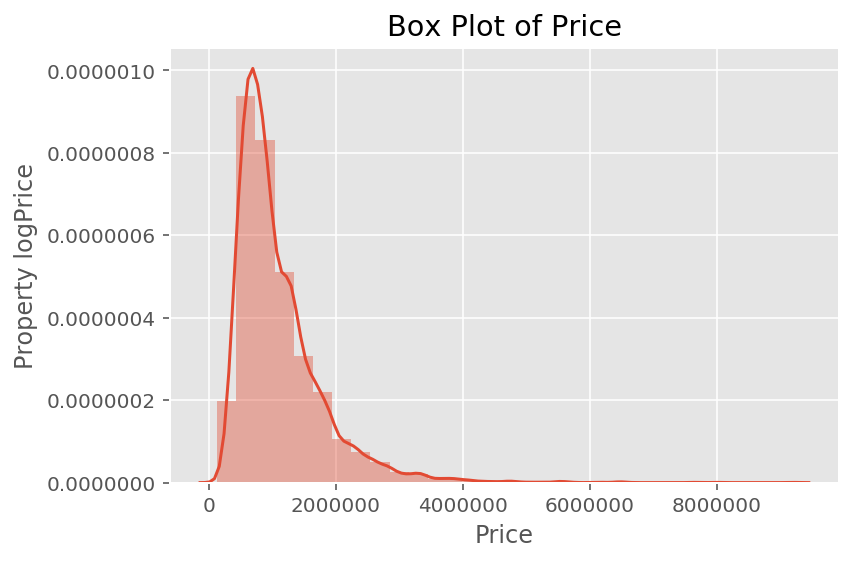

In [336]:
plt.subplot(1, 1, 1)
sns.distplot(df.Price, bins=30)
plt.title('Box Plot of Price')
plt.ylabel('Property logPrice');

In [337]:
#generate logPrice and drop Price from model
df['logPrice'] = np.log(df.Price)
df = df.drop(columns=['Price'])

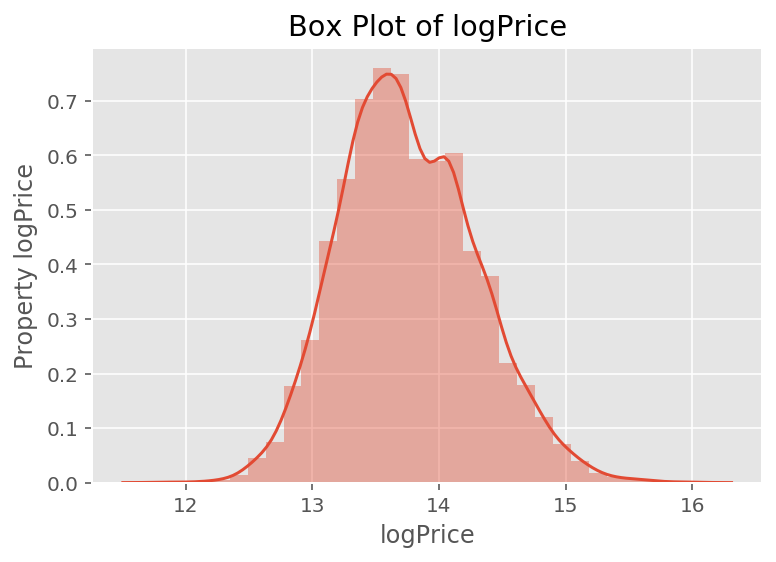

In [338]:
#generate plot of logPrice, distribution will be nice and normal!
plt.subplot(1, 1, 1)
sns.distplot(df.logPrice, bins=30)
plt.title('Box Plot of logPrice')
plt.ylabel('Property logPrice');

In [339]:
df.shape

(8808, 11)

After data cleaning there are 8,808 data rows, 7 continuous predictor variables, 3 categorical predictor variables and 1 continuous  response variable.

# Exploring the Data <a name="explore_data"></a>

Our dataset is considered clean so we can begin visualising and statistical modelling. 

In [340]:
from sklearn.decomposition import PCA

# Create PCA (reduced to three dimensions), put in dataframe
pca = PCA(n_components=3)
onehot_df = pd.get_dummies(df, drop_first=True)
pca.fit(onehot_df)
pca_reduced_x = pca.transform(onehot_df)
pca_reduced_x_df = pd.DataFrame()
pca_reduced_x_df['pca1'] = pca_reduced_x[:,0]
pca_reduced_x_df['pca2'] = pca_reduced_x[:,1] 
pca_reduced_x_df['pca3'] = pca_reduced_x[:,2] 

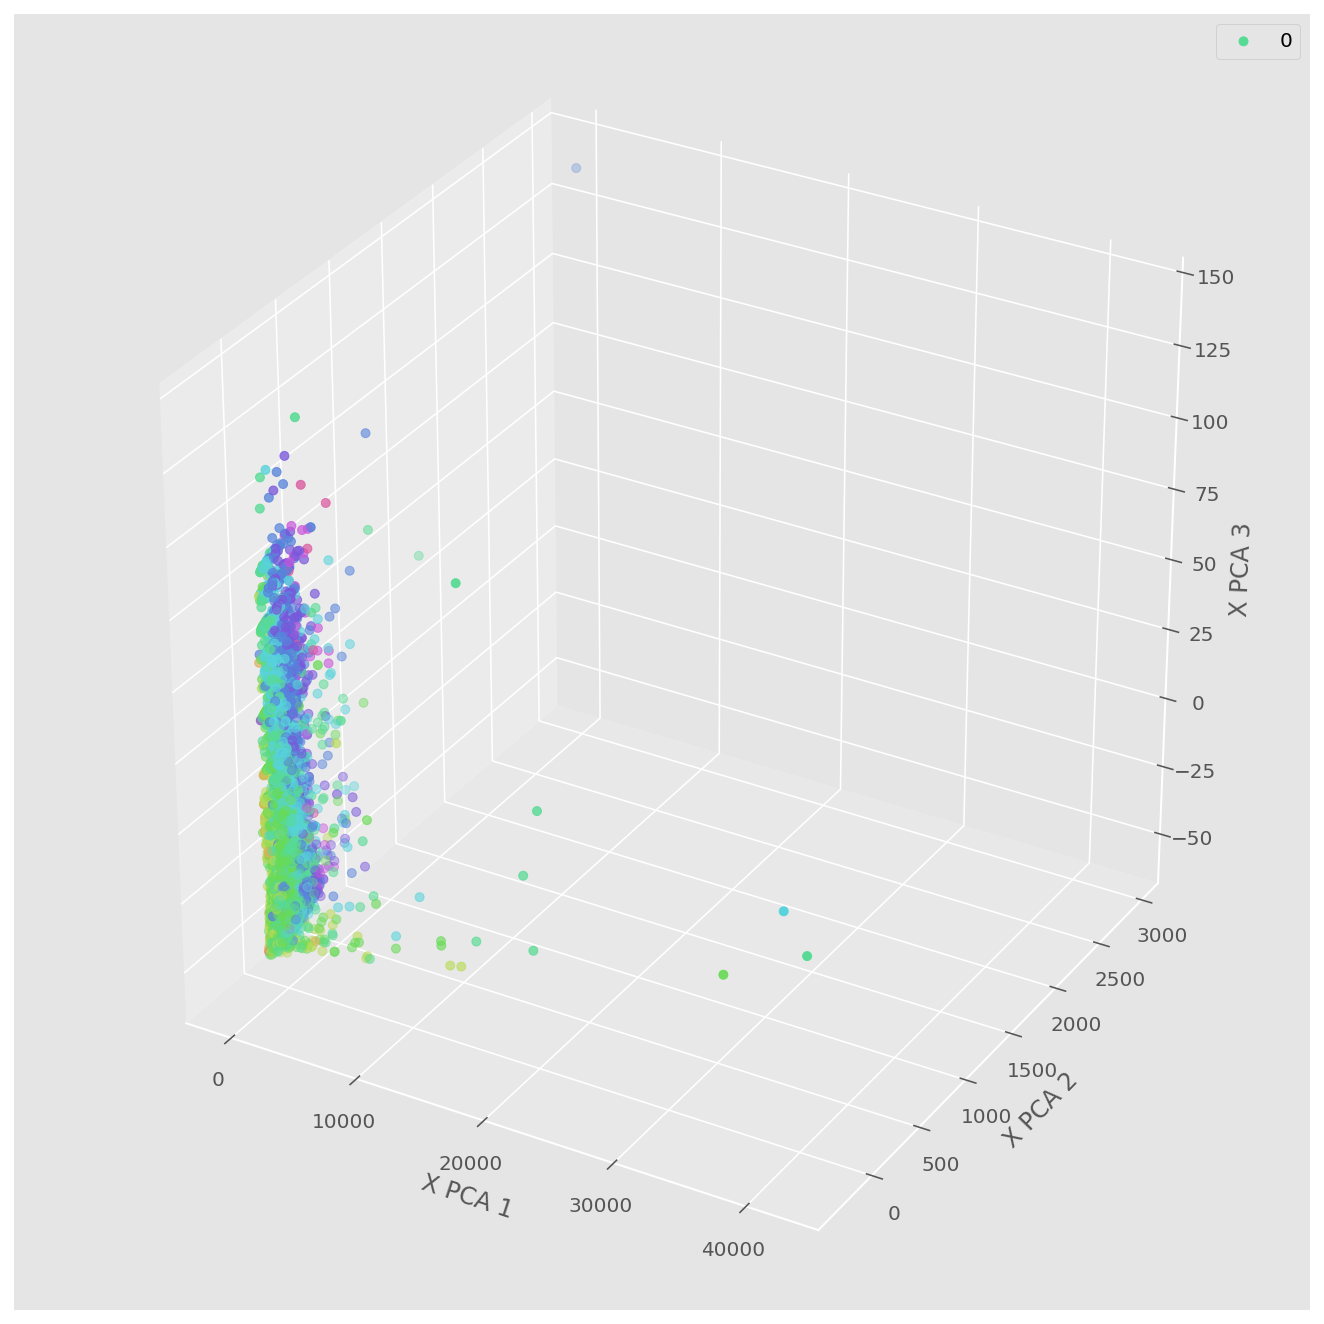

In [341]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from matplotlib.pyplot import cm, draw, figure, plot, show

# Create scatterplot 
fig = plt.figure(figsize=(9,9))

ax = Axes3D(fig)
ax.scatter(pca_reduced_x[:,0], pca_reduced_x[:,1], pca_reduced_x[:,2], c = df['logPrice'], marker='o', cmap=ListedColormap(sns.color_palette("hls", 10)))
ax.set_xlabel('X PCA 1')
ax.set_ylabel('X PCA 2')
ax.set_zlabel('X PCA 3')
plt.legend(labels=["0","1"])
plt.show()

Our dimensionally reduced PCA analysis shows high linearity in our data with clear boundaries, suggesting a linear regression model would best suit.

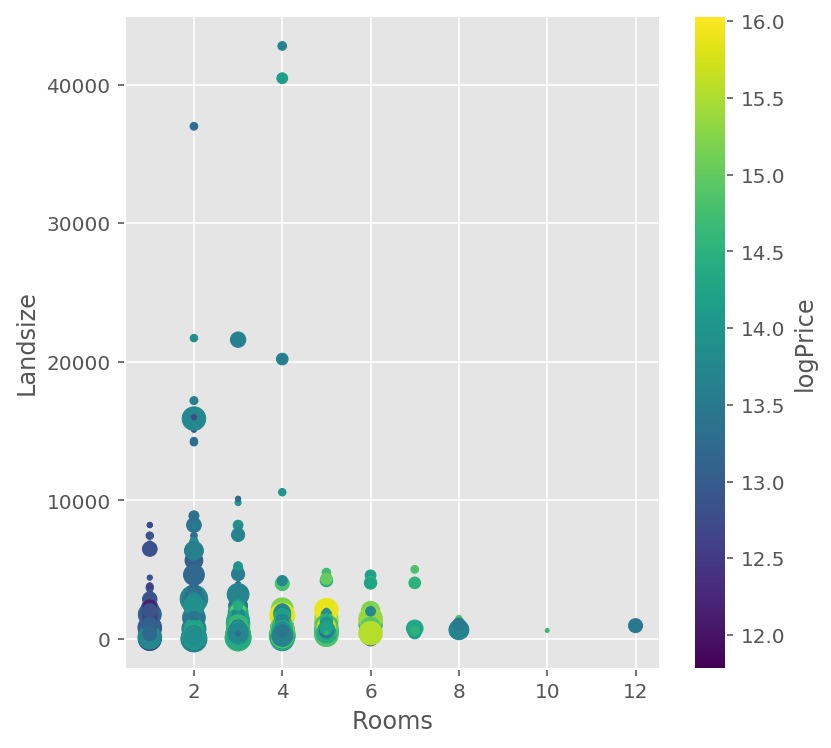

In [342]:
fig = plt.figure(figsize=(6,6))

#ax = Axes(fig)

x = df['Rooms']
y = df['Landsize']
z = df['Age']

plt.scatter(x, y, s=z, c=df['logPrice'], cmap='viridis', marker='o')
plt.xlabel('Rooms')
plt.ylabel('Landsize')
#ax.set_zlabel('Age')
plt.colorbar(label='logPrice')

plt.show()

A plot of Rooms, Age (observable by size of dot, which we constructed from YearBuilt) and Landsize against logPrice. It seems that the Age of a house has a slightly negative relation with logPrice - especially at the lower end of the market, when number of rooms are equal, suggesting older housing stock is less valuable. Our data appears to mainly contain 2-4 bedroom houses, the amount of rooms has a high correlation with increased value. The most valuable houses appear to be larger, newer housing. Curiously Landsize is not hugely correlated with price

## A broad view of the interaction of the numeric variables <a name="explore_numeric"></a>

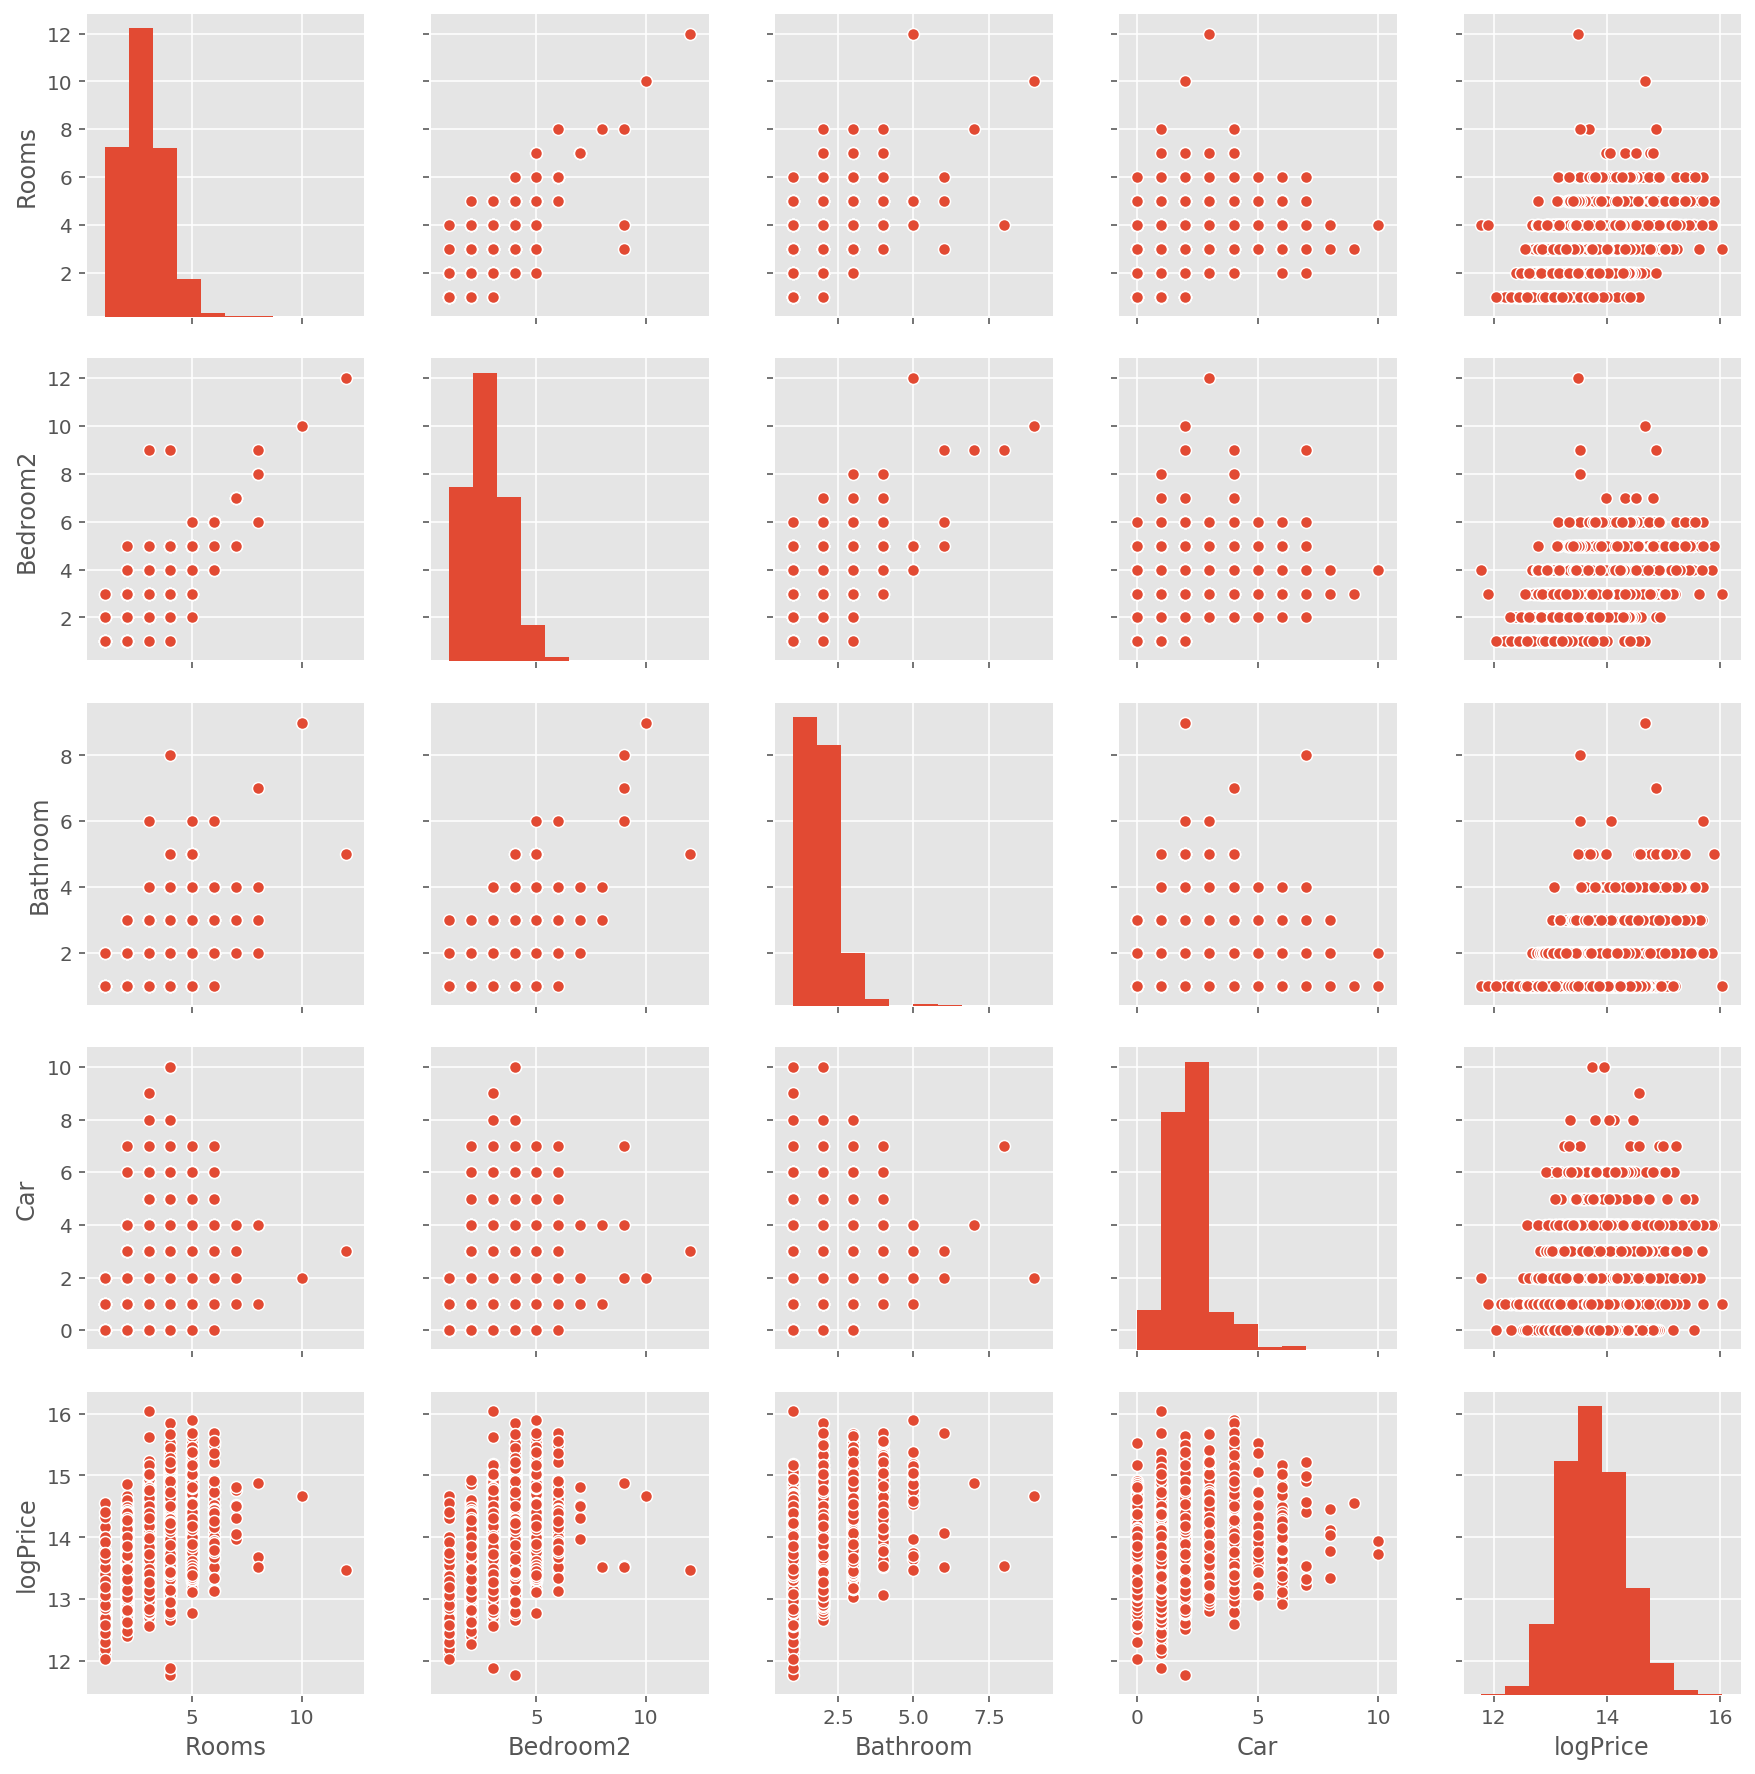

In [343]:
display(HTML('<b>Pairplot of numeric predictor variables and target variable (logPrice)</b>'))
sns.pairplot(df, vars=['Rooms', 'Bedroom2', 'Bathroom', 'Car', 'logPrice']);

From the above pairplot we can conclude:
* Bedroom2 and Rooms has a strong linear relationship with each other.
* Both Bedroom2 and Rooms have a linear relationship with Bathroom.
* Bedroom2 and Rooms have an obvious, though not strong, linear relationship with logPrice.
* Car has a weak linear relationship with logPrice. However we shall keep it to see if it is removed due to low p-value.
* The histogram for logPrice appears normal.

All of the above variables will be entered into the model as is.


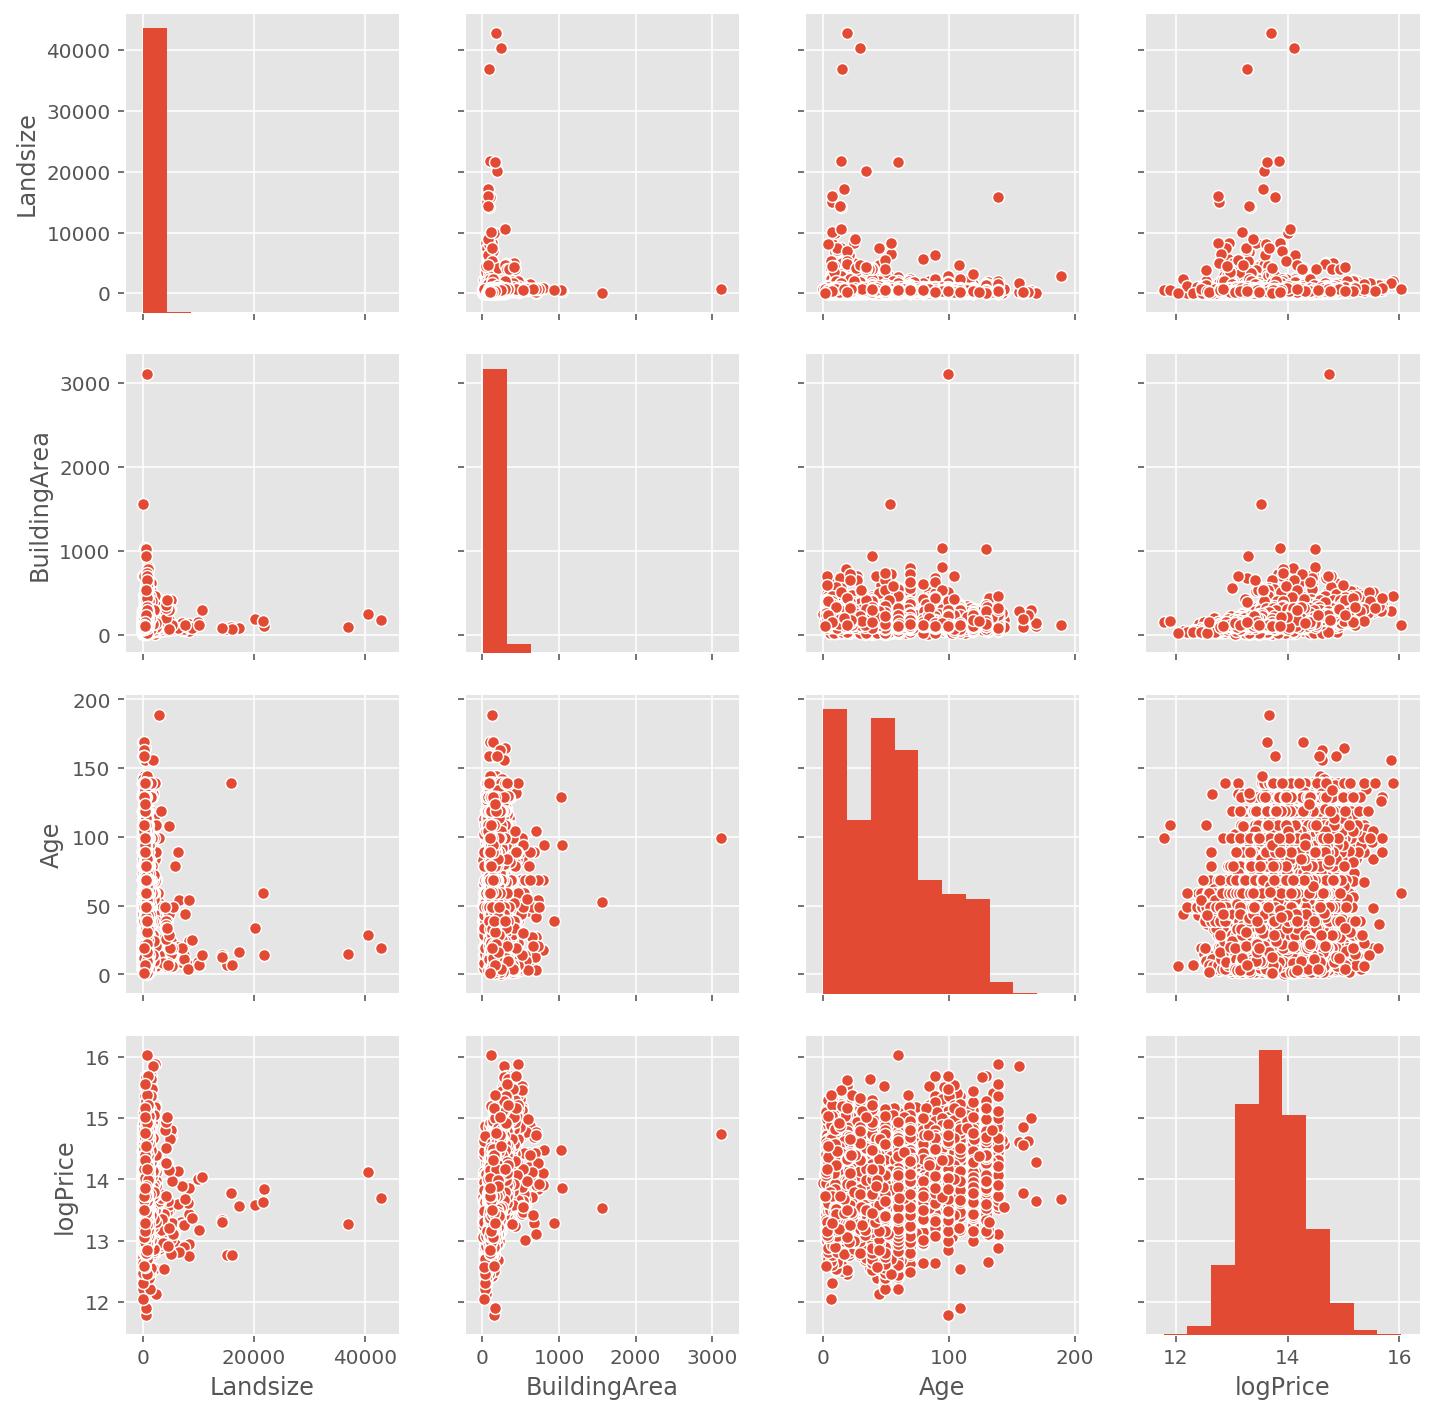

In [344]:
display(HTML('<b>Pairplot of numeric predictor variables and target variable (logPrice)</b>'))
sns.pairplot(df, vars=['Landsize', 'BuildingArea', 'Age', 'logPrice']);

* It is hard to visualy see a relationship between the predictors and the logPrice.
* Age is noticeable right skewed

## Explore the target variable (logPrice)<a name="explore_target"></a>

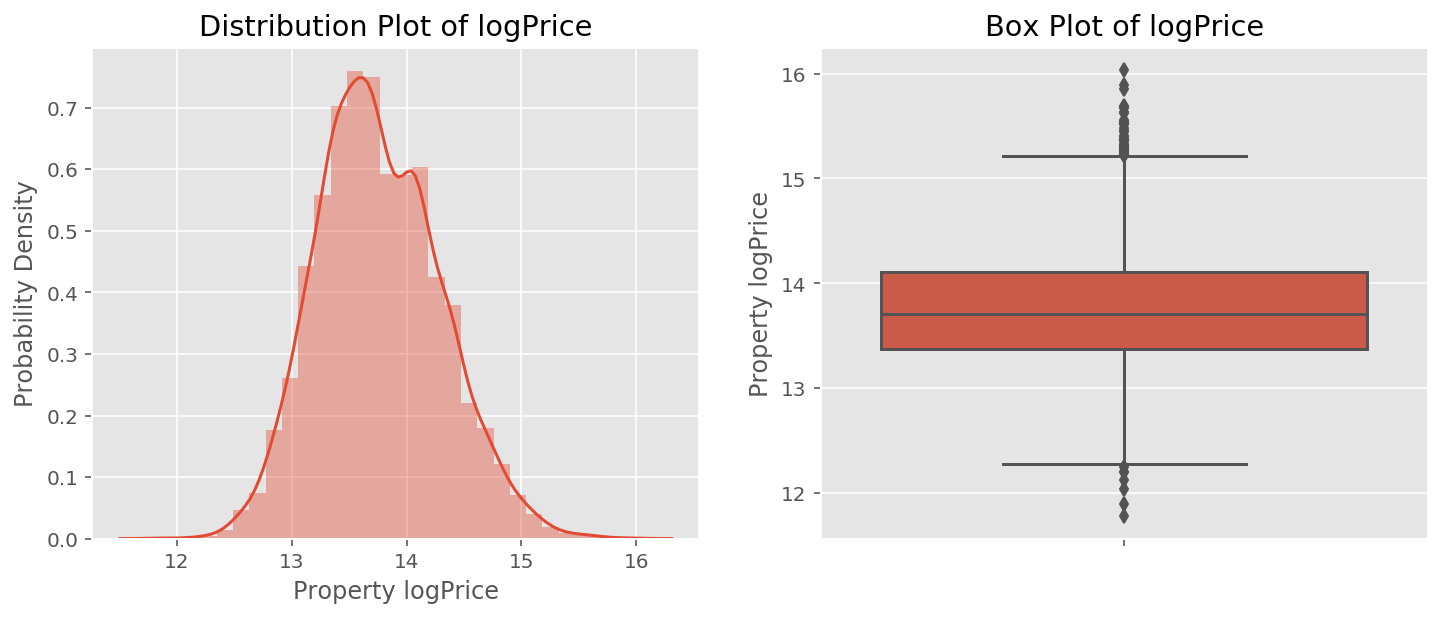

In [345]:
display(HTML('<b>Exploring the target variable (logPrice)</b>'))
# box plot and historgram
plt.subplots(figsize=(10, 4))
plt.tight_layout()

plt.subplot(1, 2, 1)
sns.distplot(df.logPrice, bins=30)
plt.title('Distribution Plot of logPrice')
plt.ylabel('Probability Density')
plt.xlabel('Property logPrice')

plt.subplot(1, 2, 2)
sns.boxplot(x=df.logPrice, orient='v')
plt.title('Box Plot of logPrice')
plt.ylabel('Property logPrice');

* The histogram of logPrice is approximately normally distributed 
* The boxplot also confirms that there is no skewness present 
* The boxplot also lets us visualise some potential outliers 

In [346]:
df.logPrice.describe()

count    8808.000000
mean       13.758122
std         0.534710
min        11.781490
25%        13.375382
50%        13.710927
75%        14.113296
max        16.032573
Name: logPrice, dtype: float64

Lets analyse the boxplot further by finding the upper and lower whiskers. 

In [347]:
quant = df.logPrice.quantile([.25, .75])
logPrice_u_wisker = quant[.75] + 1.5 * (quant[.75] - quant[.25])
print('The upper whisker for logPrice is %.0f which is equivalent to $%.0f' % (logPrice_u_wisker, math.e**logPrice_u_wisker))

logPrice_lower_wisker = quant[.25] - 1.5 * (quant[.75] - quant[.25])
print('The lower whisker for logPrice is %.0f which is equivalent to $%.0f' % (logPrice_lower_wisker, math.e**logPrice_lower_wisker))


logPrice_above = df[df.logPrice > logPrice_u_wisker]
print('The percentage of logPrices as outliers over the upper whisker is %.1f%%' % (100.0 * logPrice_above.size / df.size))

logPrice_below = df[df.logPrice < logPrice_lower_wisker]
print('The percentage of logPrices as outliers below the lower whisker is %.1f%%' % (100.0 * logPrice_below.size / df.size))

The upper whisker for logPrice is 15 which is equivalent to $4074127
The lower whisker for logPrice is 12 which is equivalent to $212886
The percentage of logPrices as outliers over the upper whisker is 0.5%
The percentage of logPrices as outliers below the lower whisker is 0.1%


The target variable (logPrice) above, looks statisticaly reasonable with only a small percentage of the data points outside of the whiskers.

## Explore Building Area <a name="explore_building"></a>

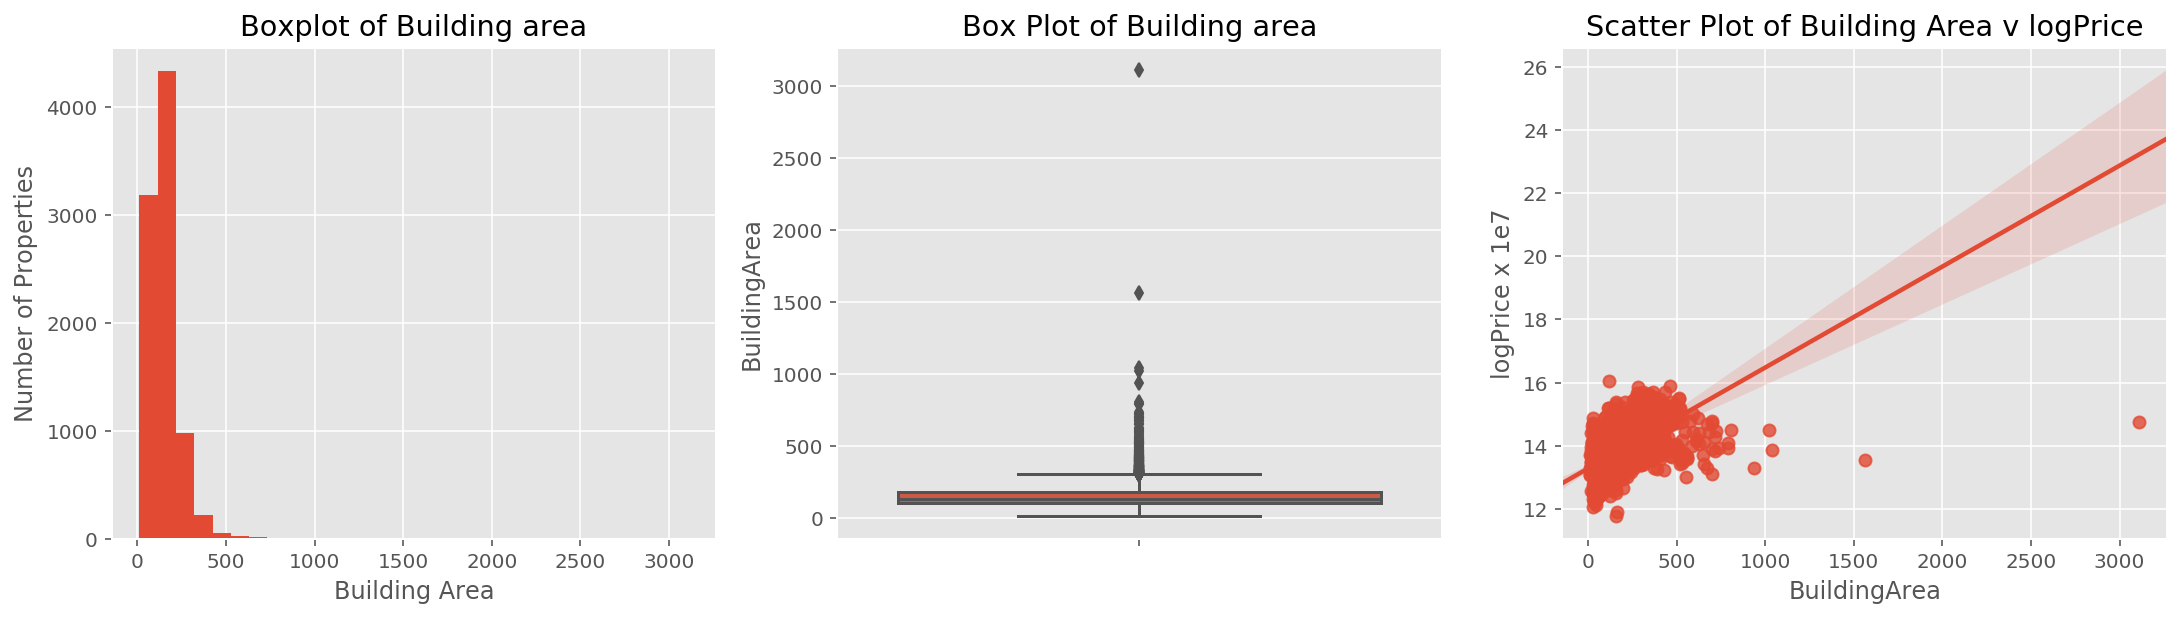

In [348]:
display(HTML('<b>Exploring Building Area.</b>'))
plt.subplots(figsize=(15, 4))
plt.tight_layout()

plt.subplot(1, 3, 1)
plt.hist(df.BuildingArea, bins=30)
plt.title('Boxplot of Building area')
plt.xlabel('Building Area')
plt.ylabel('Number of Properties')

plt.subplot(1, 3, 2)
sns.boxplot(x=df.BuildingArea, orient='v')
plt.title('Box Plot of Building area')

plt.subplot(1, 3, 3)
sns.regplot(x=df.BuildingArea, y=df.logPrice)
plt.title('Scatter Plot of Building Area v logPrice')
plt.ylabel('logPrice x 1e7');

Building area is heavily right skewed as evidenced by the histogram

On closer examination BuildingArea shows a linear relationship with logPrice. The boxplot reveals two likely outliers that may cause problems

The scatterplot shows a somewhat visible correlation between the variables BuildingArea and logPrice

## Explore Type, House, Terrace and Unit <a name="explore_type"></a>

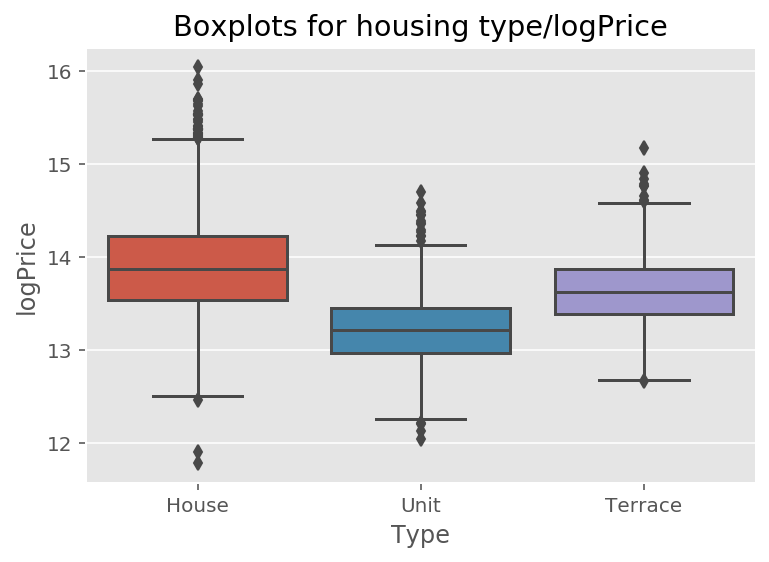

In [349]:
sns.boxplot(x=df.Type, y=df.logPrice, orient='v')
plt.xticks([0, 1, 2], ['House', 'Unit', 'Terrace'])
plt.title('Boxplots for housing type/logPrice');

In [350]:
house = df[df.Type == 'h']
terrace = df[df.Type == 't']
unit = df[df.Type == 'u']

type = pd.DataFrame(list(zip(house.logPrice, terrace.logPrice, unit.logPrice)), columns=['House', 'Terrace', 'Unit'])
type.describe()

,House,Terrace,Unit
count,703.000000,703.000000,703.000000
mean,14.147795,13.635121,13.180396
std,0.448997,0.389200,0.354249
min,11.781490,12.664165,12.280836
25%,13.829680,13.385352,12.935313
50%,14.139013,13.622170,13.160694
75%,14.430362,13.865669,13.406463
max,15.522596,15.164532,14.688696


Housing type looks statistically reasonable.

The boxplot of Type vs logPrice above highlights the narrow IQR and relationship of housing types with each other
The distributions of House, Unit and Terrace differ, but all seem somewhat symmetric
The whiskers suggest that Houses seem to be the most expensive, with a mean logPrice of 14.16, compared to 13.63 and 13.19 for Terrace and Unit respectively.

## Explore Rooms <a name="explore_rooms"></a>

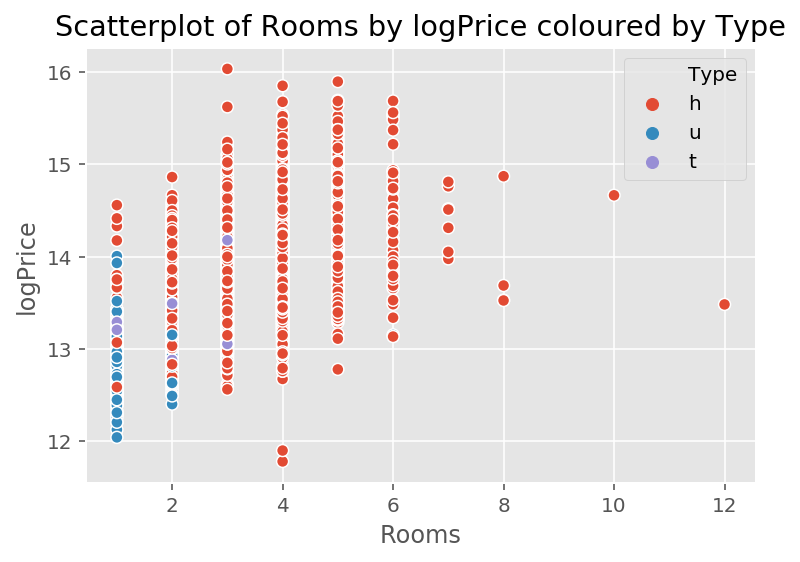

In [351]:
sns.scatterplot(df['Rooms'], df['logPrice'], hue = df['Type'])
plt.title('Scatterplot of Rooms by logPrice coloured by Type')
plt.legend(loc = 'upper right')
plt.show()

From the scatterplot above we can see that generally the more rooms you have, the greater the price

Houses typically have more bedrooms than Units, and also have a greater range of prices

There is one house with 12 bedrooms but has a logPrice below the mean. This is probably due to location or condition of the house.

# Building the model <a name="building_model"></a>

In [352]:
# formula containing all of the reduced set of predictors
formula = 'logPrice ~ Suburb + Rooms + Type + Method + Bedroom2 + Bathroom + Car + Landsize + BuildingArea + Age'

## Model One <a name="model_one"></a>
## All predictors used without removing any high p-value columns.
Model1, build and evaluate a naive regression model, containing all of the filtered predictors without removing any columns with high p-values in the result.

In [353]:
# code block courtesy of Dr V Aksakalli (Aksakalli, 2019).

def plot_line(axis, slope, intercept, **kargs):
    xmin, xmax = axis.get_xlim()
    plt.plot([xmin, xmax], [xmin*slope+intercept, xmax*slope+intercept], **kargs)

In [354]:
# fit the model
model1 = ols(formula=formula, data=df)
start = time.time()
res1 = model1.fit()
end = time.time()
print('Time in to fit Model1 = %.4fsec' % (end - start))

Time in to fit Model1 = 0.4870sec


In [355]:
print(res1.summary())

                            OLS Regression Results                            
Dep. Variable:               logPrice   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     127.2
Date:                Sun, 27 Oct 2019   Prob (F-statistic):               0.00
Time:                        17:13:22   Log-Likelihood:                 837.20
No. Observations:                8808   AIC:                            -1018.
Df Residuals:                    8480   BIC:                             1305.
Df Model:                         327                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

## Model 1 Evaluation

## Model1, R^2 and adjusted R^2

In [356]:
print('Model1 R^2 \t\t: %.4f' % res1.rsquared)
print('Model1 R^2 adjusted \t: %.4f' % res1.rsquared_adj)

Model1 R^2 		: 0.8307
Model1 R^2 adjusted 	: 0.8241


In [357]:
predict1 = res1.predict(df)
results1 = pd.DataFrame(list(zip(df.logPrice, predict1, predict1 - df.logPrice)), columns=['logPrice', 'Predict', 'Residual'])
results1.describe()

,logPrice,Predict,Residual
count,8808.000000,8808.000000,8.808000e+03
mean,13.758122,13.758122,7.550404e-14
std,0.534710,0.487336,2.200432e-01
min,11.781490,12.288454,-2.421074e+00
25%,13.375382,13.385729,-1.278765e-01
50%,13.710927,13.740818,-1.975265e-03
75%,14.113296,14.100044,1.268998e-01
max,16.032573,17.327465,2.580347e+00


Model1 produced a good result with a R^2 of 83% and a residual mean of 4.9e-14.

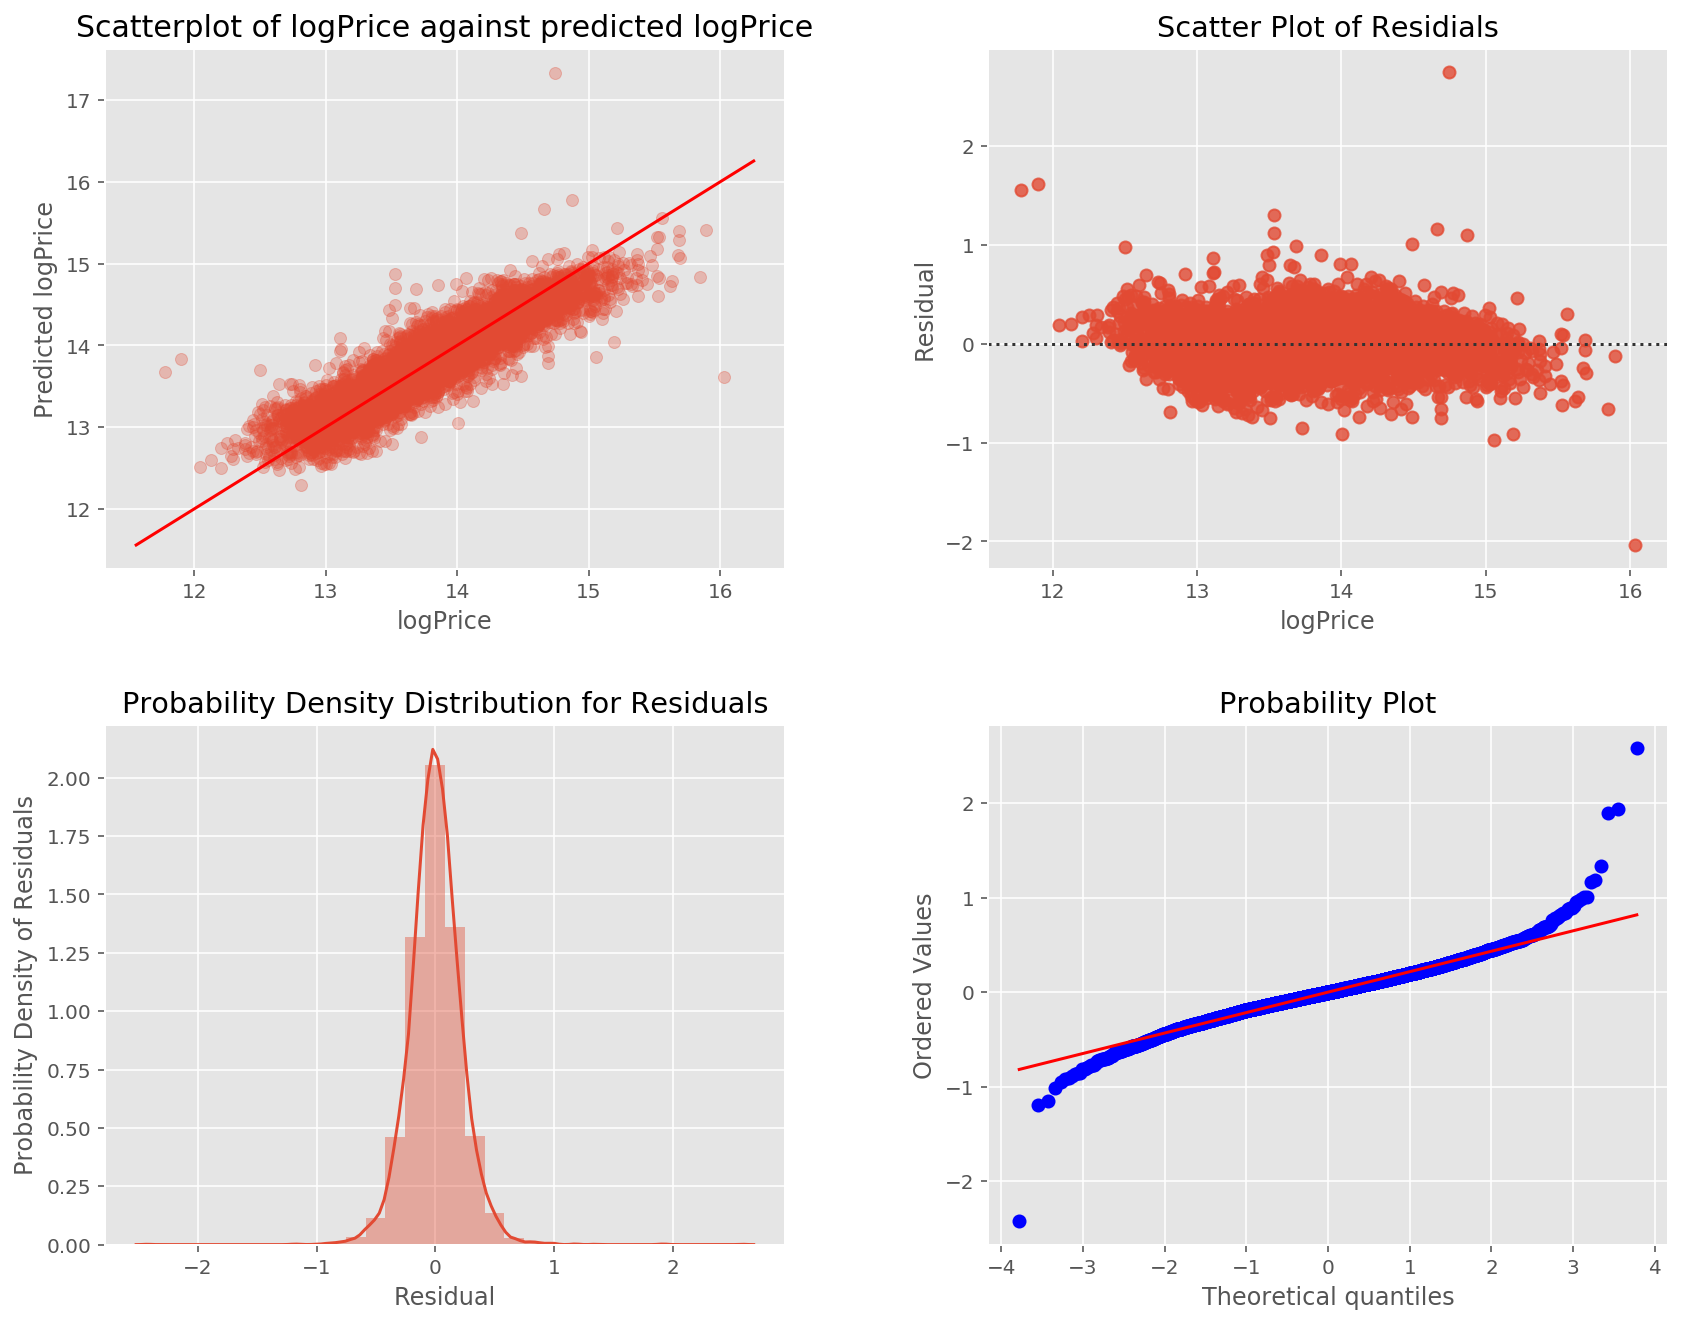

In [358]:
display(HTML('<b>Model1 Evaluation plots.</b>'))
plt.subplots(figsize=(14, 11))
#plt.tight_layout()
plt.subplots_adjust(wspace = 0.3, hspace=0.3)

plt.subplot(2, 2, 1)
plt.scatter(df['logPrice'], results1.Predict, alpha=0.3);
plot_line(axis=plt.gca(), slope=1, intercept=0, c="red");
plt.xlabel('logPrice');
plt.ylabel('Predicted logPrice');
plt.title('Scatterplot of logPrice against predicted logPrice', fontsize=15);

#plt.subplot(2, 2, 1)
#sns.boxplot(data=results1, orient='v')
#plt.title('Box Plot for Actual logPrice, Predicted logPrice and Prediction Residuals')
#plt.ylabel('Dollars')


plt.subplot(2, 2, 2)
sns.residplot(x=results1.logPrice, y=results1.Residual)
plt.title('Scatter Plot of Residials')
#plt.xticks(rotation=10)
#plt.yticks(rotation=35)

plt.subplot(2, 2, 3)
sns.distplot(results1.Residual, bins=30)
plt.title('Probability Density Distribution for Residuals')
plt.ylabel('Probability Density of Residuals')

plt.subplot(2, 2, 4)
stat = stats.probplot(results1.Residual, plot=plt)
#plt.yticks(rotation=35);


The plot of our residuals show a fairly random distribution, and the probablity density distribution appears normal. This is a good indication that our data is linear and ergo a good match for our model.

# Model 2 <a name="model_two"></a>
Model2 aims to build and evaluate a naive regression model, containing a subset of the filtered predictors. Numerical column with high p-values are removed, whilst categoricals are not removed due to high p-values. Instead, categorical dummies are removed as a whole for the original categorical. Furthermore, the categoricals are removed subjectively rather than objectively. The subjectivity is based on perceived importance assesed by human opion of the number and size of the p-values. The reasoning behind this approach is to determine how a quick and dirty approach to feature selection compares to the other moddels.

### Removing columns with high p-values, removing categories at as a whole instead of independant dummies.

NB: The regression was part optimised by carrying out an initial regression containing all of the independant variables. Subsequently, removing variables with the highest p-value over 5%. The multiple definitions for the formula string is a trace of the optimisation process.

In [359]:
# Everything included, r^2 = 0.787
formula2 = 'logPrice ~ Suburb + Rooms + Type + Method + Bedroom2 + Bathroom + \
        Car + Landsize + BuildingArea + Age'

# Method removed due high p-values ~ 0.49, r^2 = 0.784
formula2 = 'logPrice ~ Suburb + Rooms + Type + Bedroom2 + Bathroom + Car + \
        Landsize + BuildingArea + Age'

# LandSize removed due high p-values ~ 0.20, r^2 = 0.784
formula2 = 'logPrice ~ Suburb + Rooms + Type + Bedroom2 + Bathroom + Car + \
        BuildingArea + Age'

# Bedroom2 removed due high p-values ~ 0.07, r^2 = 0.784
formula2 = 'logPrice ~ Suburb + Rooms + Type + Bathroom + Car + \
        BuildingArea + Age'

# at this point all p-values except for some Suburbs are < 0.000
# dropping suburb drops the r^2 to approx 0.52

model2 = ols(formula=formula2, data=df)
start = time.time()
res2 = model2.fit()
end = time.time()
print('Time in to fit Model2 = %.4fsec' % (end - start))

Time in to fit Model2 = 0.5132sec


Model2 removed Method, LandSize and Bedroom2.

In [360]:
print(res2.summary())

                            OLS Regression Results                            
Dep. Variable:               logPrice   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     125.3
Date:                Sun, 27 Oct 2019   Prob (F-statistic):               0.00
Time:                        17:13:26   Log-Likelihood:                 711.42
No. Observations:                8808   AIC:                            -778.8
Df Residuals:                    8486   BIC:                             1502.
Df Model:                         321                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

## Model2 Evaluation

## Model 2, R^2 and adjusted R^2

In [361]:
print('Model2, R^2 \t\t: %.4f' % res2.rsquared)
print('Model2, R^2 adjusted \t: %.4f' % res2.rsquared_adj)

Model2, R^2 		: 0.8257
Model2, R^2 adjusted 	: 0.8192


In [362]:
predict2 = res2.predict(df)
results2 = pd.DataFrame(list(zip(df.logPrice, predict2, predict2 - df.logPrice)), columns=['logPrice', 'Predict', 'Residual'])
results2.describe()

,logPrice,Predict,Residual
count,8808.000000,8808.000000,8.808000e+03
mean,13.758122,13.758122,3.244312e-14
std,0.534710,0.485894,2.232080e-01
min,11.781490,12.317202,-2.338843e+00
25%,13.375382,13.386821,-1.301474e-01
50%,13.710927,13.742563,-3.199217e-03
75%,14.113296,14.099045,1.289288e-01
max,16.032573,17.299767,2.552648e+00


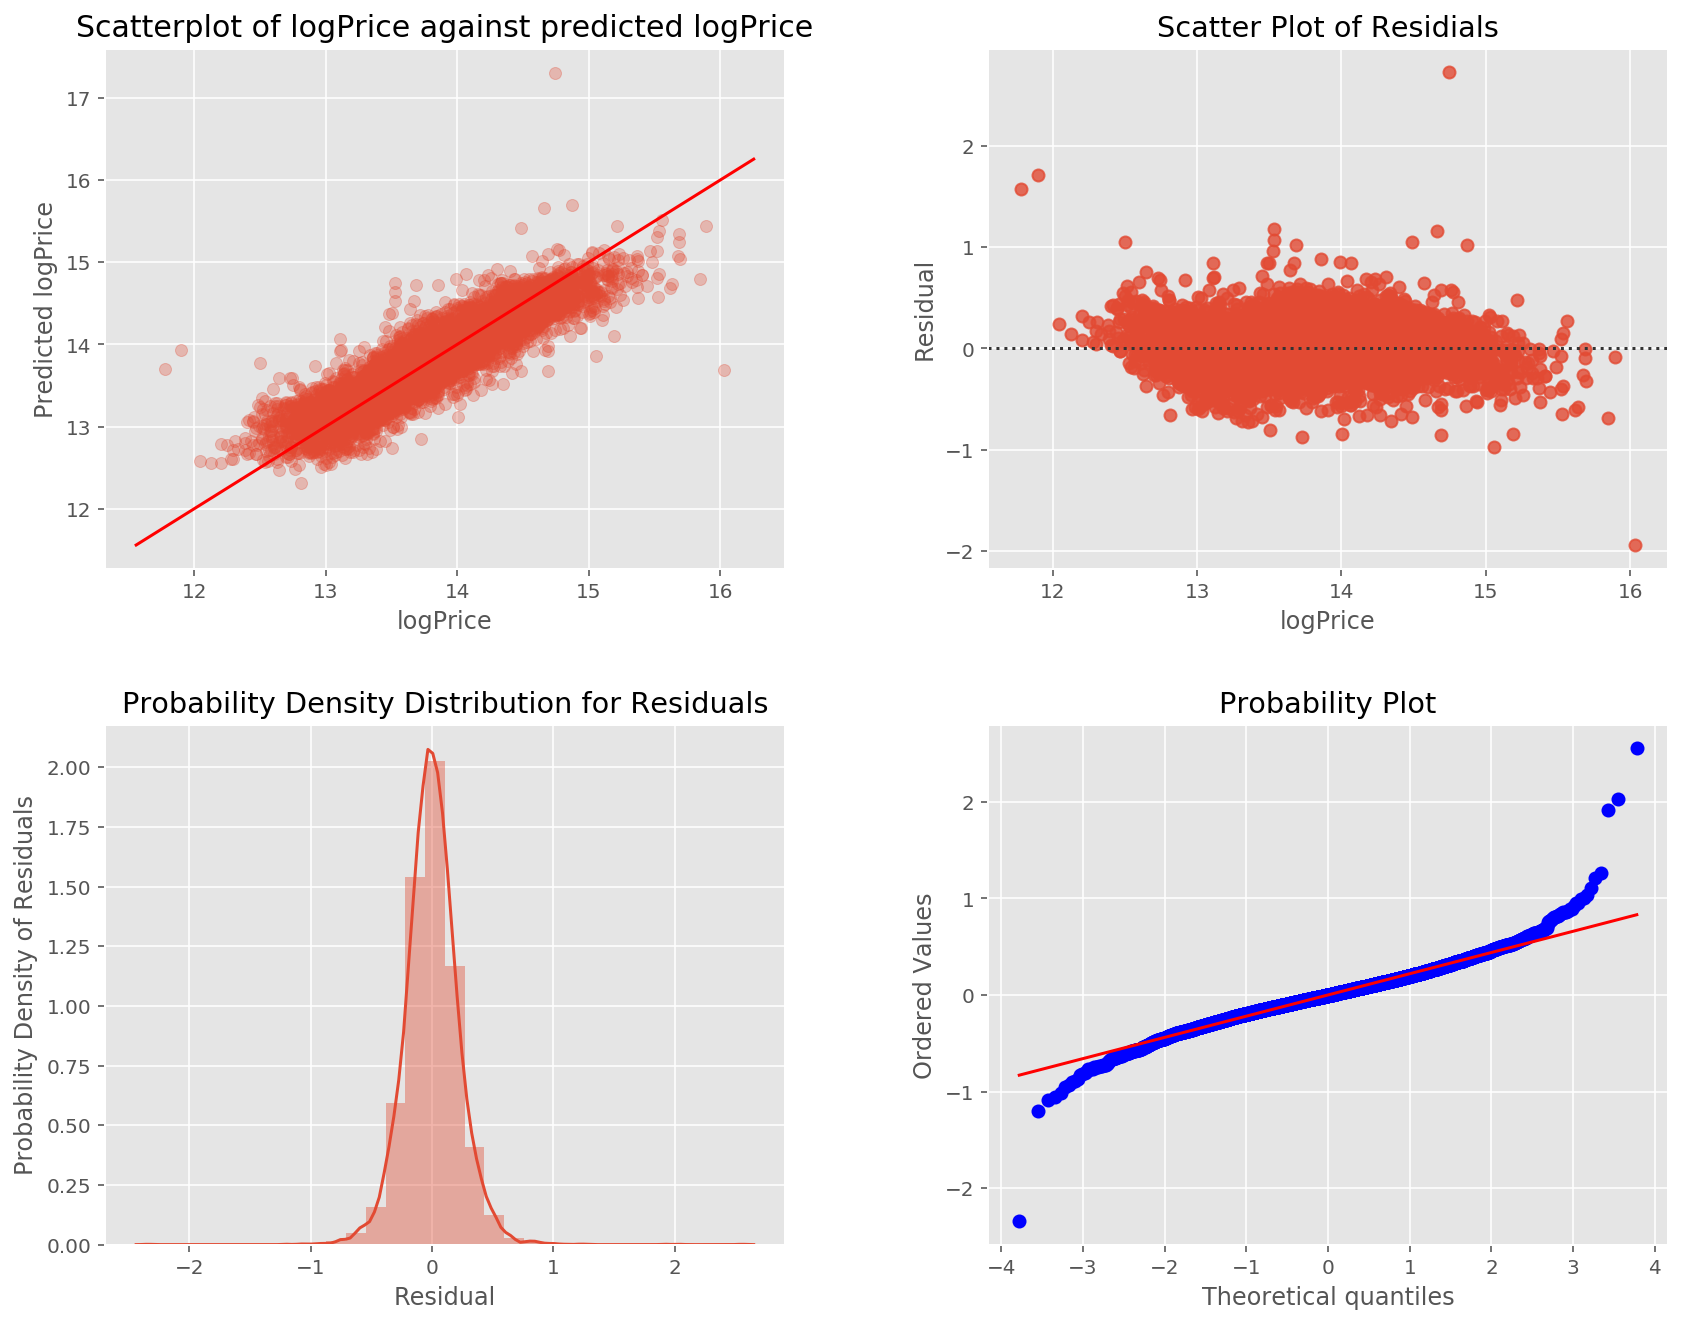

In [363]:
display(HTML('<b>Model2 Evaluation plots.</b>'))
plt.subplots(figsize=(14, 11))
#plt.tight_layout()
plt.subplots_adjust(wspace = 0.3, hspace=0.3)

plt.subplot(2, 2, 1)
plt.scatter(df['logPrice'], results2.Predict, alpha=0.3);
plot_line(axis=plt.gca(), slope=1, intercept=0, c="red");
plt.xlabel('logPrice');
plt.ylabel('Predicted logPrice');
plt.title('Scatterplot of logPrice against predicted logPrice', fontsize=15); 

#plt.subplot(2, 2, 1)
#sns.boxplot(data=results2, orient='v')
#plt.title('Box Plot for Actual logPrice, Predicted logPrice and Prediction Residuals')
#plt.ylabel('Dollars')


plt.subplot(2, 2, 2)
sns.residplot(x=results2.logPrice, y=results2.Residual)
plt.title('Scatter Plot of Residials')
#plt.xticks(rotation=10)
#plt.yticks(rotation=35)

plt.subplot(2, 2, 3)
sns.distplot(results2.Residual, bins=30)
plt.title('Probability Density Distribution for Residuals')
plt.ylabel('Probability Density of Residuals')

plt.subplot(2, 2, 4)
stat = stats.probplot(results2.Residual, plot=plt)
#plt.yticks(rotation=35);

The plot of our residuals show a fairly random distribution, and the probablity density distribution appears normal. This is a good indication that our data is linear and ergo a good match for our model. Unfortunately the adjusted R^2 score for this model has gone down, indicating a fault in our selection techniques. Additionally our adjusted R^2 value has increase from our naive model with further variables, a further negative indicator for our naive feature selection.

# Model3 <a name="model_three"></a>
## Removing all columns with high p-values > 5%.
Model3 is the technicaly correct model where columns are sequentialy removed on the basis of the highest p-value. This process is automated by code provided by Dr V Aksakalli (Aksakalli, 2019).

In [364]:
#formula_string_indep_vars = ' + '.join(df.drop(columns='logPrice').columns)
#formula_string = 'logPrice ~ ' + formula_string_indep_vars
#print('formula_string: ', formula_string)

In [365]:
# code block courtesy of Dr V Aksakalli (Aksakalli, 2019).

# one-hot-encoding of categorical features
data_encoded = pd.get_dummies(df, drop_first=True)
data_encoded.head()

,Rooms,Bedroom2,Bathroom,Car,Landsize,BuildingArea,Age,logPrice,Suburb_Aberfeldie,Suburb_Airport_West,...,Suburb_Wyndham_Vale,Suburb_Yallambie,Suburb_Yarra_Glen,Suburb_Yarraville,Type_t,Type_u,Method_S,Method_SA,Method_SP,Method_VB
2,2,2.0,1.0,0.0,156.0,79.0,119.0,13.864826,0,0,...,0,0,0,0,0,0,1,0,0,0
4,3,3.0,2.0,0.0,134.0,150.0,119.0,14.197005,0,0,...,0,0,0,0,0,0,0,0,1,0
6,4,3.0,1.0,2.0,120.0,142.0,5.0,14.300428,0,0,...,0,0,0,0,0,0,0,0,0,1
11,3,4.0,2.0,0.0,245.0,210.0,109.0,14.434400,0,0,...,0,0,0,0,0,0,1,0,0,0
14,2,2.0,1.0,2.0,256.0,107.0,129.0,14.305567,0,0,...,0,0,0,0,0,0,1,0,0,0


In [366]:
formula_string_indep_vars_encoded = ' + '.join(data_encoded.drop(columns='logPrice').columns)
formula_string_encoded = 'logPrice ~ ' + formula_string_indep_vars_encoded
print('formula_string_encoded: ', formula_string_encoded)

formula_string_encoded:  logPrice ~ Rooms + Bedroom2 + Bathroom + Car + Landsize + BuildingArea + Age + Suburb_Aberfeldie + Suburb_Airport_West + Suburb_Albanvale + Suburb_Albert_Park + Suburb_Albion + Suburb_Alphington + Suburb_Altona + Suburb_Altona_Meadows + Suburb_Altona_North + Suburb_Ardeer + Suburb_Armadale + Suburb_Ascot_Vale + Suburb_Ashburton + Suburb_Ashwood + Suburb_Aspendale + Suburb_Aspendale_Gardens + Suburb_Attwood + Suburb_Avondale_Heights + Suburb_Bacchus_Marsh + Suburb_Balaclava + Suburb_Balwyn + Suburb_Balwyn_North + Suburb_Bayswater + Suburb_Bayswater_North + Suburb_Beaconsfield + Suburb_Beaconsfield_Upper + Suburb_Beaumaris + Suburb_Bellfield + Suburb_Bentleigh + Suburb_Bentleigh_East + Suburb_Berwick + Suburb_Black_Rock + Suburb_Blackburn + Suburb_Blackburn_North + Suburb_Blackburn_South + Suburb_Bonbeach + Suburb_Boronia + Suburb_Botanic_Ridge + Suburb_Box_Hill + Suburb_Braybrook + Suburb_Briar_Hill + Suburb_Brighton + Suburb_Brighton_East + Suburb_Broadmeadows 

In [367]:
# code block courtesy of Dr V Aksakalli (Aksakalli, 2019).

# starting from the full model
model_full = sm.formula.ols(formula=formula_string_encoded, data=data_encoded)
###
model_full_fitted = model_full.fit()
###
print(model_full_fitted.summary())

                            OLS Regression Results                            
Dep. Variable:               logPrice   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     127.2
Date:                Sun, 27 Oct 2019   Prob (F-statistic):               0.00
Time:                        17:13:31   Log-Likelihood:                 837.20
No. Observations:                8808   AIC:                            -1018.
Df Residuals:                    8480   BIC:                             1305.
Df Model:                         327                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

### We now perform backwards variable selection using p-values. 

In [368]:
# code block courtesy of Dr V Aksakalli (Aksakalli, 2019).

## create the patsy model desc from formula
my_linreg_patsy = patsy.ModelDesc.from_formula(formula_string_encoded)
###
# initialize variable-selected fit to full model
linreg_fit = model_full_fitted

start = time.time()
#########
## do backwards elimination using p-values
p_val_cutoff = 0.05
for i in range(len(linreg_fit.model.exog_names)):
    pval_series = linreg_fit.pvalues.copy()
    pval_series.sort_values(ascending=False, inplace=True)
    term = pval_series.index[0]
    pval = pval_series[0]
    if (pval < p_val_cutoff):
        break
    print(f"iteration: {i}, removing term: {term}, p-value: {pval:.3f}")
    terms = term.split(':')
    if (len(terms) == 1): ## this is a main effect term
        my_linreg_patsy.rhs_termlist.remove(patsy.Term([patsy.EvalFactor(term)]))    
    else: ## this is an interaction term
        my_linreg_patsy.rhs_termlist.remove(patsy.Term([patsy.EvalFactor(terms[0]), patsy.EvalFactor(terms[1])]))    
    linreg_fit = ols(formula = my_linreg_patsy, data = data_encoded).fit()
#########
end = time.time()
print('Time in to fit Model3 = %.4fsec' % (end - start))

###
## this is the clean fit after backwards elimination
model_reduced_fitted = ols(formula = my_linreg_patsy, data = data_encoded).fit()
###
    
#########
print("***")
print(model_reduced_fitted.summary())
print("***")
print(f"Regression number of terms: {len(model_reduced_fitted.model.exog_names)}")
print(f"Regression F-distribution p-value: {model_reduced_fitted.f_pvalue}")
print(f"Regression R-squared: {model_reduced_fitted.rsquared:.3f}")
print(f"Regression Adjusted R-squared: {model_reduced_fitted.rsquared_adj:.3f}")

iteration: 0, removing term: Suburb_Collingwood, p-value: 0.936
iteration: 1, removing term: Suburb_Melbourne, p-value: 0.876
iteration: 2, removing term: Suburb_North_Melbourne, p-value: 0.890
iteration: 3, removing term: Suburb_Ripponlea, p-value: 0.814
iteration: 4, removing term: Suburb_Cremorne, p-value: 0.788
iteration: 5, removing term: Suburb_Fairfield, p-value: 0.782
iteration: 6, removing term: Suburb_Ivanhoe, p-value: 0.733
iteration: 7, removing term: Suburb_Caulfield_North, p-value: 0.705
iteration: 8, removing term: Suburb_Aberfeldie, p-value: 0.663
iteration: 9, removing term: Suburb_Glen_Waverley, p-value: 0.693
iteration: 10, removing term: Suburb_Mount_Waverley, p-value: 0.644
iteration: 11, removing term: Suburb_Caulfield_South, p-value: 0.542
iteration: 12, removing term: Suburb_Carlton, p-value: 0.490
iteration: 13, removing term: Suburb_Box_Hill, p-value: 0.433
iteration: 14, removing term: Suburb_West_Melbourne, p-value: 0.450
iteration: 15, removing term: Suburb

## Model3 evaluation
### Model 3, R^2 and adjusted R^2

In [369]:
print('Model3, R^2 \t\t: %.4f' % model_reduced_fitted.rsquared)
print('Model3, R^2 adjusted \t: %.4f' % model_reduced_fitted.rsquared_adj)

Model3, R^2 		: 0.8295
Model3, R^2 adjusted 	: 0.8238


In [370]:
predict3 = model_reduced_fitted.fittedvalues
results3 = pd.DataFrame(list(zip(df.logPrice, predict3, predict3-df.logPrice)), columns=['logPrice', 'Predict', 'Residual'])
results3.describe()

,logPrice,Predict,Residual
count,8808.000000,8808.000000,8.808000e+03
mean,13.758122,13.758122,-3.004140e-13
std,0.534710,0.486994,2.207978e-01
min,11.781490,12.292601,-2.414953e+00
25%,13.375382,13.387590,-1.277100e-01
50%,13.710927,13.740581,-2.646332e-03
75%,14.113296,14.097773,1.278326e-01
max,16.032573,17.317951,2.570833e+00


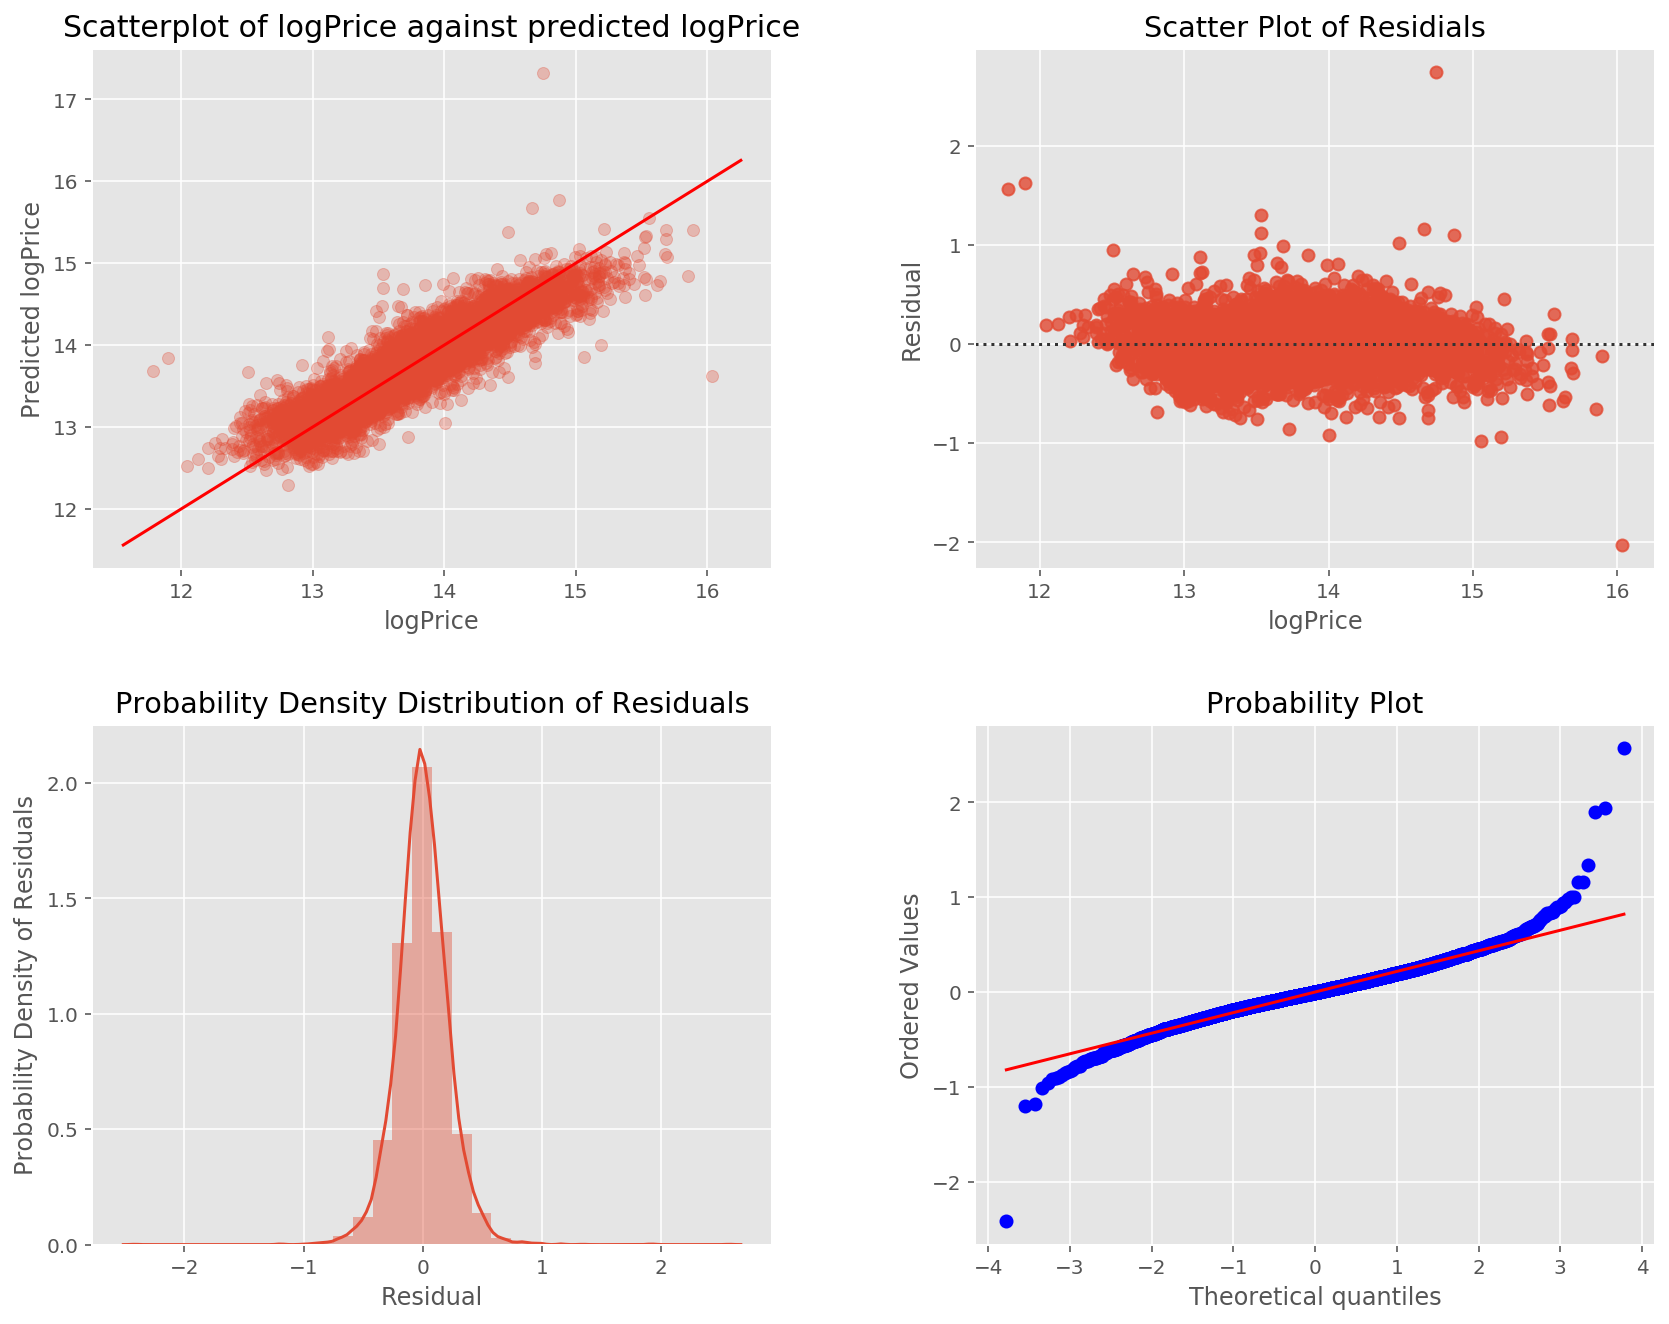

In [371]:
display(HTML('<b>Model3 Evaluation plots.</b>'))
plt.subplots(figsize=(14, 11))
#plt.tight_layout()
plt.subplots_adjust(wspace = 0.3, hspace=0.3)

plt.subplot(2, 2, 1)
plt.scatter(df['logPrice'], model_reduced_fitted.fittedvalues, alpha=0.3);
plot_line(axis=plt.gca(), slope=1, intercept=0, c="red");
plt.xlabel('logPrice');
plt.ylabel('Predicted logPrice');
plt.title('Scatterplot of logPrice against predicted logPrice', fontsize=15); 

#sns.boxplot(data=results3, orient='v')
#plt.title('Box Plot for Actual logPrice, Predicted logPrice and Prediction Residuals')
#plt.ylabel('Dollars')


plt.subplot(2, 2, 2)
sns.residplot(x=results3.logPrice, y=results3.Residual)
plt.title('Scatter Plot of Residials')
#plt.xticks(rotation=10)
#plt.yticks(rotation=35)

plt.subplot(2, 2, 3)
sns.distplot(results3.Residual, bins=30)
plt.title('Probability Density Distribution of Residuals')
plt.ylabel('Probability Density of Residuals')

plt.subplot(2, 2, 4)
stat = stats.probplot(results3.Residual, plot=plt)
#plt.yticks(rotation=35);

The plot of our residuals show a fairly random distribution, and the probablity density distribution appears normal. This is a good indication that our data is linear and ergo a good match for our model. Additionally a decreased R^2 score indicates our selection has increased the accuracy of our model.

# Compare the three models <a name="compare"></a>
Here we present a statistical comparrison of the residuals for each of the three models.

In [372]:
residuals_all = pd.DataFrame(list(zip(results1.Residual, results2.Residual, results3.Residual)), columns=['Residuals1', 'Residuals2', 'Residuals3'])
logPrice_all = pd.DataFrame(list(zip(results1.Predict, results2.Predict, results3.Predict, df.logPrice)), columns=['Predict1', 'Predict2', 'Predict3', 'logPrice'])


In [373]:
residuals_all.reset_index(drop=True, inplace=True)
logPrice_all.reset_index(drop=True, inplace=True)

results_all = pd.concat( [residuals_all, logPrice_all], axis=1) 

In [374]:
results_all.describe()

,Residuals1,Residuals2,Residuals3,Predict1,Predict2,Predict3,logPrice
count,8.808000e+03,8.808000e+03,8.808000e+03,8808.000000,8808.000000,8808.000000,8808.000000
mean,7.550404e-14,3.244312e-14,-3.004140e-13,13.758122,13.758122,13.758122,13.758122
std,2.200432e-01,2.232080e-01,2.207978e-01,0.487336,0.485894,0.486994,0.534710
min,-2.421074e+00,-2.338843e+00,-2.414953e+00,12.288454,12.317202,12.292601,11.781490
25%,-1.278765e-01,-1.301474e-01,-1.277100e-01,13.385729,13.386821,13.387590,13.375382
50%,-1.975265e-03,-3.199217e-03,-2.646332e-03,13.740818,13.742563,13.740581,13.710927
75%,1.268998e-01,1.289288e-01,1.278326e-01,14.100044,14.099045,14.097773,14.113296
max,2.580347e+00,2.552648e+00,2.570833e+00,17.327465,17.299767,17.317951,16.032573


As can be seen from the above table. There is no significant statistical difference between the residuals of the three models.

However there has been a slight increase in adjusted R^2 scores for the third model indicating our selections and use of Dr V Aksakalli (Aksakalli, 2019) methods have yielded positive results.

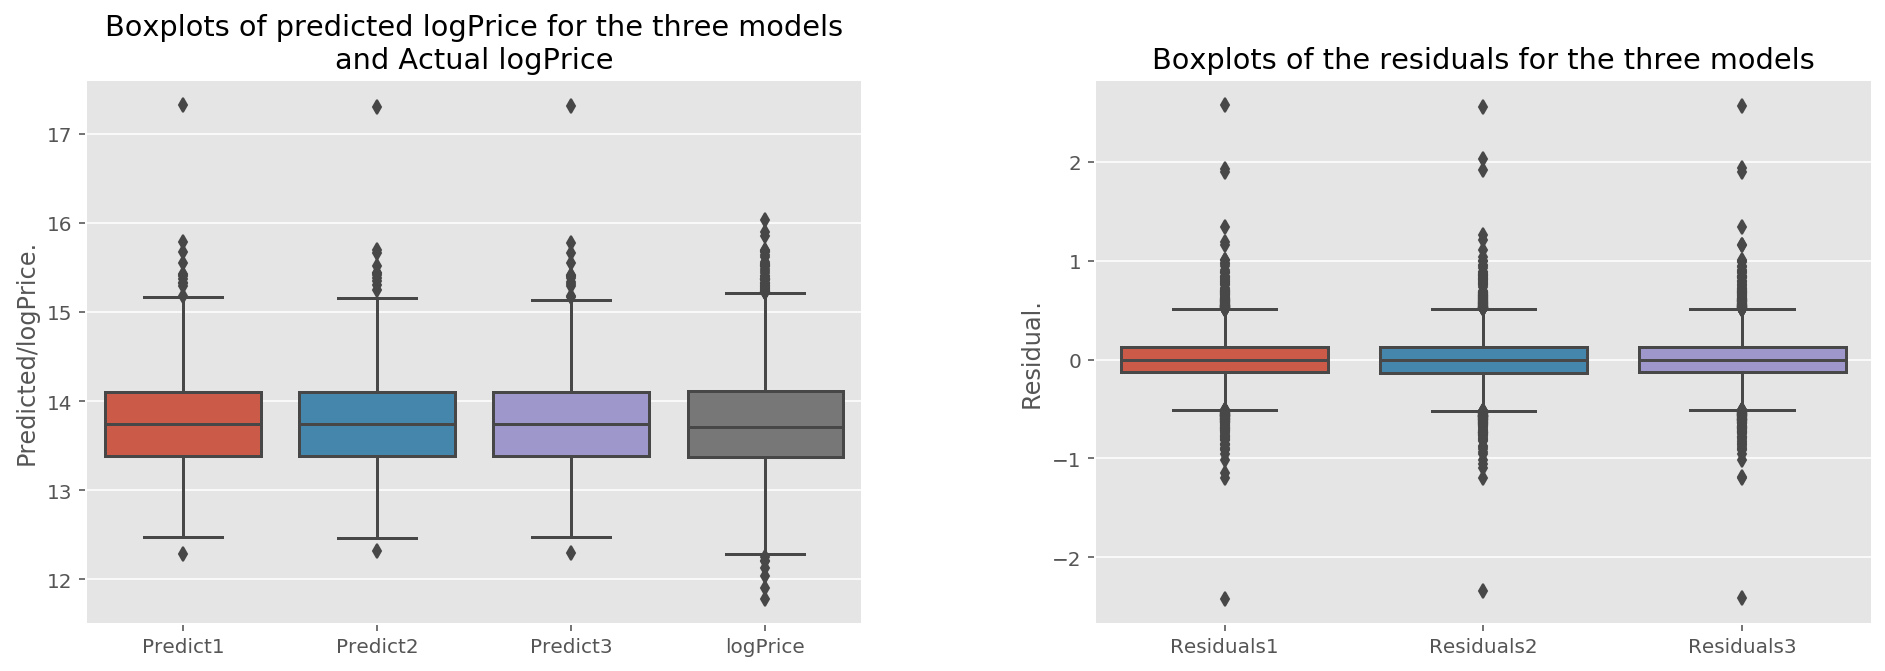

In [375]:
display(HTML('<b>Comparison of the three models.</b>'))
plt.subplots(figsize=(16, 5))
#plt.tight_layout()
plt.subplots_adjust(wspace = 0.3, hspace=0.3)

plt.subplot(1, 2, 1)
sns.boxplot(data=logPrice_all, orient='v')
plt.title('Boxplots of predicted logPrice for the three models\nand Actual logPrice')
plt.ylabel('Predicted/logPrice.');

plt.subplot(1, 2, 2)
sns.boxplot(data=residuals_all, orient='v')
plt.title('Boxplots of the residuals for the three models')
plt.ylabel('Residual.');

Our residuals appear somewhat tighter in the boxplot of our third model, indicating a slightly superior fit to our naive approaches.

# Summary and Conclusion <a name="summary"></a>
The goal of this report is to train a multiple linear regression model for the valuation of Melbourne housing prices and evaluate the models performance. The data source used was the Kaggel Melbourne Houding FULL dataset (Kaggle, 2019). Raw data was cleaned, evaluated and filtered, removing redundant data columns and ID like features. The Price data was found to be heavily right skewed. Therefore, an additional variable, the log base e of Price was generated as the target feature. In production the predicted price may be determined by finding the antilog of the predicted logPrice.

Model selection consisted of: 
1. Naive, consisting of all the cleaned data, with no further feature reduction.
2. Partial feature reduction, removing numerical and categorical features that had a p-value greater than 5% with the exception that individual unique values of categoricals were not removed. Instead if a categorical was  removed all values were removed as a whole. Furthermore, this method was not made in a disciplined manner, rather the p-values were manually inspected categorical groups removed subjectively.
3. The third model represents the technically correct procedure with features being suquentialy removed on the basis of the highest p-value goes first then the model is retrained until all features with a p-value greater than 5% are removed.

All three models produced similar results with an adjusted R-squared of approximately 82.5%. Additionally, all three models produced near identical plots of the prediction and prediction residuals. The logPrice/predicted LogPrice shows a tightly bound random group centered about the diagonal line with a handful of random outliers forming no particular pattern. The scatter plot of residuals confirms the comclusion derived prom the logPrice plot once again exhibiting a tight random pattern about the zero axis. The historgram of residuals shows a convincingly normal pattern with wide tails which is supportorted by the probability plot with shows a strong linear relationship for the body of the plot with divergences at either end.

Boxplots were generated to aid in evaluating differences in the three models. These plots reinforce the view that this report has produced no evidence to conclude that any of the three models is supperior to the other two. A further metric  'time to fit' was generated to compare the computational cost of each model. Model1 and model2 each took approx 0.6sec to fit the model per itteration where model took 65sec and removed 44 features.

The mean, standard deviation and IQR of actual logPrice compare to predicted is almost identical with the predicted having slightly narrower wiskers. Predicted boxplots all reveal a single extreme outlier which turns out to be an unassuming properter is Camberwell on a larger than normal block of land. This is explained as the buyer paid high premium for the property for personal reasons not caught by the dataset.

In conclusion three successful models were trained prodicing similar excellent results using different feature selection. With the tweaking of our models yielding little differences however our third model coming out ahead with high R^2 and adjusted R^2 scores :^)

## Appendix: The outlier in residual <a name="appendix"></a>

This house curiously does not correlate with what we would expect using our models. Viewing the property on google maps suggest that there is additional construction that might indicate a covered swimming pool, possible skewing the price.

In [376]:
'''
Suburb                        Camberwell
Address                  46 Athelstan Rd
Rooms                                  5
Type                                   h
Price                          2.608e+06
Method                                 S
SellerG                         Marshall
Date                          15/10/2016
Distance                             7.8
Postcode                            3124
Bedroom2                               5
Bathroom                               2
Car                                    4
Landsize                             730
BuildingArea                        3112
YearBuilt                           1920
CouncilArea      Boroondara City Council
Lattitude                       -37.8424
Longtitude                       145.064
Regionname         Southern Metropolitan
Propertycount                       8920
Name: 2704, dtype: object
'''



'\nSuburb                        Camberwell\nAddress                  46 Athelstan Rd\nRooms                                  5\nType                                   h\nPrice                          2.608e+06\nMethod                                 S\nSellerG                         Marshall\nDate                          15/10/2016\nDistance                             7.8\nPostcode                            3124\nBedroom2                               5\nBathroom                               2\nCar                                    4\nLandsize                             730\nBuildingArea                        3112\nYearBuilt                           1920\nCouncilArea      Boroondara City Council\nLattitude                       -37.8424\nLongtitude                       145.064\nRegionname         Southern Metropolitan\nPropertycount                       8920\nName: 2704, dtype: object\n'

In [377]:
math.e**16.25


11409991.763828434

# References <a name="references"></a>
Aksakalli, V. (2019). Regression case study 1. Available at https://rmit.instructure.com/courses/50622/files/9243116/download/ [accessed 2019-10-17]

Kaggle (2019). Melbourne housing clearance data from jan 2016, Version(27). Available at https://www.kaggle.com/anthonypino/melbourne-housing-market [accessed 2019-10-17] 

O'Meara, B. (2019). Data sets for machine learning. Available at https://github.com/Bernie059/datasets [accessed 2019-10-17]<br>

Trading Economics (2019). Australia House Price Index QoQ. Available at https://tradingeconomics.com/australia/housing-index

Trading Economics (2019). Australia Inflation Rate. Available at 
https://tradingeconomics.com/australia/inflation-cpi
